# Phase 3 - Modeling

In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns

# Load sklearn utilities
# ----------------------
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score

from sklearn.calibration import calibration_curve

# Load classifiers
# ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier

# Other Packages
# --------------
from scipy.stats import kendalltau
from sklearn.neural_network import MLPRegressor
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
# from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
# from scipy.interpolate import spline

# Load debugger, if required
#import pixiedust
pd.options.mode.chained_assignment = None #'warn'

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

C:\Users\kolpe\AppData\Local\Temp\ipykernel_2244\1354391861.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# Define a function that, given a CVGridSearch object, finds the
# percentage difference between the best and worst scores
def find_score_variation(cv_model):
    all_scores = cv_model.cv_results_['mean_test_score']
    return( np.abs((max(all_scores) - min(all_scores))) * 100 / max(all_scores) )

    '''
    which_min_score = np.argmin(all_scores)
    
    all_perc_diff = []
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score - 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    try:
        all_perc_diff.append( np.abs(all_scores[which_min_score + 1] - all_scores[which_min_score])*100 / min(all_scores) )
    except:
        pass
    
    return ( np.mean(all_perc_diff) )
    '''

# Define a function that checks, given a CVGridSearch object,
# whether the optimal parameters lie on the edge of the search
# grid
def find_opt_params_on_edge(cv_model):
    out = False
    
    for i in cv_model.param_grid:
        if cv_model.best_params_[i] in [ cv_model.param_grid[i][0], cv_model.param_grid[i][-1] ]:
            out = True
            break
            
    return out

## Define a default random seed and an output file

In [3]:
default_seed = 1
output_file = "output_sample"

In [4]:
# Create a function to print a line to our output file

def dump_to_output(key, value):
    with open(output_file, "a") as f:
        f.write(",".join([str(default_seed), key, str(value)]) + "\n")

## Load the data and engineer the features

In [135]:
# Read the data and features from the pickle file saved in CS-Phase 2
data, discrete_features, continuous_features, ret_cols = pickle.load( open( "clean_data.pickle", "rb" ) )

In [136]:
data.drop(columns=['id'],inplace=True)

In [137]:
# categorical_cols = ['grade', 'emp_length', 'home_ownership', 'verification_status', 'purpose']

# data = pd.get_dummies(data, columns=categorical_cols, drop_first=True)

In [138]:
## Create the outcome columns: True if loan_status is either Charged Off or Default, False otherwise
data["outcome"] = data["loan_status"].apply(lambda x: True if x in ["Charged Off", "Default"] else False)

In [139]:
# Create a feature for the length of a person's credit history at the time the loan is issued
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])

data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / 30
continuous_features.append('cr_hist')

In [121]:
# data['cr_hist'] = data['cr_hist'].dt.days.values

In [140]:
data.drop(columns=['loan_status','earliest_cr_line'],inplace=True)

In [141]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 540792 entries, 0 to 2777771
Data columns (total 30 columns):
 #   Column               Non-Null Count   Dtype          
---  ------               --------------   -----          
 0   loan_amnt            540792 non-null  float64        
 1   funded_amnt          540792 non-null  float64        
 2   term                 540792 non-null  object         
 3   int_rate             540792 non-null  float64        
 4   grade                540792 non-null  object         
 5   emp_length           507859 non-null  object         
 6   home_ownership       540792 non-null  object         
 7   annual_inc           540792 non-null  float64        
 8   verification_status  540792 non-null  object         
 9   issue_d              540792 non-null  datetime64[ns] 
 10  purpose              540792 non-null  object         
 11  dti                  540792 non-null  float64        
 12  delinq_2yrs          540792 non-null  float64        
 13  ope

In [124]:
# from imblearn.over_sampling import SMOTE
# from sklearn.model_selection import train_test_split
# import pandas as pd

# # Separate features (X) and target variable (y)
# X = data.drop(columns=['outcome', 'issue_d', 'last_pymnt_d'])  # Assuming 'outcome' is the target variable
# y = data['outcome']

# # Apply SMOTE to balance the data
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X, y)

# # Check the balance of the resampled data
# resampled_counts = pd.Series(y_resampled).value_counts()
# print(resampled_counts)

# # Concatenate the resampled data with the original majority class data
# resampled_data = pd.concat([pd.DataFrame(X_resampled, columns=X.columns), pd.DataFrame(y_resampled, columns=['outcome'])], axis=1)


In [142]:
# Randomly assign each row to a training and test set. We do this now because we will be fitting a variety of models on various time periods, and we would like every period to use the *same* training/test split
np.random.seed(default_seed)
## create the train columns where the value is True if it is a train instance and False otherwise. Hint: use np.random.choice with 70% for training and 30% for testing
data['train'] = np.random.choice([True, False], size=len(data), p=[0.7, 0.3])

In [217]:
# Create a matrix of features and outcomes, with dummies. Record the names of the dummies for later use
X_continuous = data[continuous_features].values

X_discrete = pd.get_dummies(data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = data.outcome.values

train = data.train.values

In [16]:
discrete_features

['home_ownership',
 'emp_length',
 'term',
 'purpose',
 'verification_status',
 'grade']

In [17]:
X

array([[5000.0, 5000.0, 24000.0, ..., False, False, False],
       [2400.0, 2400.0, 12252.0, ..., False, False, False],
       [10000.0, 10000.0, 49200.0, ..., False, False, False],
       ...,
       [7500.0, 7500.0, 45000.0, ..., False, False, False],
       [15000.0, 15000.0, 124800.0, ..., False, False, False],
       [3000.0, 3000.0, 44000.0, ..., False, False, False]], dtype=object)

In [18]:
len(y)

540792

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 540792 entries, 0 to 2777771
Data columns (total 31 columns):
 #   Column               Non-Null Count   Dtype          
---  ------               --------------   -----          
 0   loan_amnt            540792 non-null  float64        
 1   funded_amnt          540792 non-null  float64        
 2   term                 540792 non-null  object         
 3   int_rate             540792 non-null  float64        
 4   grade                540792 non-null  object         
 5   emp_length           507859 non-null  object         
 6   home_ownership       540792 non-null  object         
 7   annual_inc           540792 non-null  float64        
 8   verification_status  540792 non-null  object         
 9   issue_d              540792 non-null  datetime64[ns] 
 10  purpose              540792 non-null  object         
 11  dti                  540792 non-null  float64        
 12  delinq_2yrs          540792 non-null  float64        
 13  ope

## Prepare functions to fit and evaluate models

In [20]:
def prepare_data(data_subset = np.array([True]*len(data)),
                    n_samples_train = 30000,
                    n_samples_test = 20000,
                    feature_subset = None,
                    date_range_train = (data.issue_d.min(), data.issue_d.max()),
                    date_range_test = (data.issue_d.min(), data.issue_d.max()),
                    random_state = default_seed):
    '''
    This function will prepare the data for classification or regression.
    It expects the following parameters:
      - data_subset: a numpy array with as many entries as rows in the
                     dataset. Each entry should be True if that row
                     should be used, or False if it should be ignored
      - n_samples_train: the total number of samples to be used for training.
                         Will trigger an error if this number is larger than
                         the number of rows available after all filters have
                         been applied
      - n_samples_test: as above for testing
      - feature_subect: A list containing the names of the features to be
                        used in the model. In None, all features in X are
                        used
      - date_range_train: a tuple containing two dates. All rows with loans
                          issued outside of these two dates will be ignored in
                          training
      - date_range_test: as above for testing
      - random_state: the random seed to use when selecting a subset of rows
      
    Note that this function assumes the data has a "Train" column, and will
    select all training rows from the rows with "True" in that column, and all
    the testing rows from those with a "False" in that column.
    
    This function returns a dictionary with the following entries
      - X_train: the matrix of training data
      - y_train: the array of training labels
      - train_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the train set
      - X_test: the matrix of testing data
      - y_test: the array of testing labels
      - test_set: a Boolean vector with as many entries as rows in the data
                  that denotes the rows that were used in the test set
    '''
    
    np.random.seed(random_state)
        
    # Filter down the data to the required date range, and downsample
    # as required
    filter_train = ( train & (data.issue_d >= date_range_train[0]) &
                            (data.issue_d <= date_range_train[1]) & data_subset ).values
    filter_test = ( (train == False) & (data.issue_d >= date_range_test[0])
                            & (data.issue_d <= date_range_test[1]) & data_subset ).values
    
    filter_train[ np.random.choice( np.where(filter_train)[0], size = filter_train.sum()
                                                   - n_samples_train, replace = False ) ] = False
    filter_test[ np.random.choice( np.where(filter_test)[0], size = filter_test.sum()
                                                   - n_samples_test, replace = False ) ] = False
    
    # Prepare the training and test set
    X_train = X[ filter_train , :]
    X_test = X[ filter_test, :]
    if feature_subset != None:
        cols = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in feature_subset]
        X_train = X_train[ : , cols ]
        X_test = X_test[ : , cols ]
        
    y_train = y[ filter_train ]
    y_test = y[ filter_test ]
    
    # Scale the variables
    scaler = preprocessing.MinMaxScaler()

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    # return training and testing data
    out = {'X_train':X_train, 'y_train':y_train, 'train_set':filter_train, 
           'X_test':X_test, 'y_test':y_test, 'test_set':filter_test}
    
    return out

In [21]:
def fit_classification(model, data_dict,
                          cv_parameters = {},
                          model_name = None,
                          random_state = default_seed,
                          output_to_file = True,
                          print_to_screen = True):
    '''
    This function will fit a classification model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    If the model provided does not have a predict_proba function, we will
    simply print accuracy diagnostics and return.
    
    If the model provided does have a predict_proba function, we first
    figure out the optimal threshold that maximizes the accuracy and
    print out accuracy diagnostics. We then print an ROC curve, sensitivity/
    specificity curve, and calibration curve.
    
    This function returns a dictionary with the following entries
      - model: the best fitted model
      - y_pred: predictions for the test set
      - y_pred_probs: probability predictions for the test set, if the model
                      supports them
      - y_pred_score: prediction scores for the test set, if the model does not 
                      output probabilities.
    '''
        
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    X_train = data_dict['X_train']
    y_train = data_dict['y_train']
    
    X_test = data_dict['X_test']
    y_test = data_dict['y_test']
    
    filter_train = data_dict['train_set']    
  
    # --------------------------
    #   Step 2 - Fit the model
    # --------------------------

    cv_model = GridSearchCV(model, cv_parameters)
    
    start_time = time.time()
    cv_model.fit(X_train, y_train)
    end_time = time.time()
    
    best_model = cv_model.best_estimator_
    
    if print_to_screen:

        if model_name != None:
            print("=========================================================")
            print("  Model: " + model_name)
            print("=========================================================")

        print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
        print("Optimal parameters:")
        print(cv_model.best_params_)
        print("")
    
    # -------------------------------
    #   Step 3 - Evaluate the model
    # -------------------------------
    
    # If possible, make probability predictions
    try:
        y_pred_probs = best_model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
        
        probs_predicted = True
    except:
        probs_predicted = False
    
    # Make predictions; if we were able to find probabilities, use
    # the threshold that maximizes the accuracy in the training set.
    # If not, just use the learner's predict function
    if probs_predicted:
        y_train_pred_probs = best_model.predict_proba(X_train)[:,1]
        fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_probs)
        
        true_pos_train = tpr_train*(y_train.sum())
        true_neg_train = (1 - fpr_train) *(1-y_train).sum()
        
        best_threshold_index = np.argmax(true_pos_train + true_neg_train)
        best_threshold = 1 if best_threshold_index == 0 else thresholds_train[ best_threshold_index ]
        
        if print_to_screen:
            print("Accuracy-maximizing threshold was: " + str(best_threshold))
        
        y_pred = (y_pred_probs > best_threshold)
    else:
        y_pred = best_model.predict(X_test)
    
    if print_to_screen:
        print("Accuracy: ", accuracy_score(y_test, y_pred))
        print(classification_report(y_test, y_pred, target_names =['No default', 'Default'], digits = 4))

    if print_to_screen:
        if probs_predicted:        
            plt.figure(figsize = (13, 4.5))
            plt.subplot(2, 2, 1)

            plt.title("ROC Curve (AUC = %0.2f)"% roc_auc_score(y_test, y_pred_probs))
            plt.plot(fpr, tpr, 'b')
            plt.plot([0,1],[0,1],'r--')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.ylabel('True Positive Rate')
            plt.xlabel('False Positive Rate')

            plt.subplot(2, 2, 3)

            plt.plot(thresholds, tpr, 'b', label = 'Sensitivity')
            plt.plot(thresholds, 1 -fpr, 'r', label = 'Specificity')
            plt.legend(loc = 'lower right')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.xlabel('Threshold')

            plt.subplot(2, 2, 2)

            fp_0, mpv_0 = calibration_curve(y_test, y_pred_probs, n_bins = 10)
            plt.plot([0,1], [0,1], 'k:', label='Perfectly calibrated')
            plt.plot(mpv_0, fp_0, 's-')
            plt.ylabel('Fraction of Positives')
            plt.xlim([0,1]); plt.ylim([0,1])
            plt.legend(loc ='upper left')
            
            plt.subplot(2, 2, 4)
            plt.hist(y_pred_probs, range=(0, 1), bins=10, histtype="step", lw=2)
            plt.xlim([0,1]); plt.ylim([0,20000])
            plt.xlabel('Mean Predicted Probability')
            plt.ylabel('Count')
            
            #plt.tight_layout()
            plt.show()
        
    # Additional Score Check
    if probs_predicted:
        y_train_score = y_train_pred_probs
    else:
        y_train_score = best_model.decision_function(X_train)
        
    tau, p_value = kendalltau(y_train_score, data.grade[filter_train])
    if print_to_screen:
        print("")
        print("Similarity to LC grade ranking: ", tau)
    
    if probs_predicted:
        brier_score = brier_score_loss(y_test, y_pred_probs)
        if print_to_screen:
            print("Brier score:", brier_score)
    
    # Return the model predictions, and the
    # test set
    # -------------------------------------
    out = {'model':best_model, 'y_pred_labels':y_pred}
    
    if probs_predicted:
        out.update({'y_pred_probs':y_pred_probs})
    else:
        y_pred_score = best_model.decision_function(X_test)
        out.update({'y_pred_score':y_pred_score})
        
    # Output results to file
    # ----------------------
    if probs_predicted and output_to_file:
        # Check whether any of the CV parameters are on the edge of
        # the search space
        opt_params_on_edge = find_opt_params_on_edge(cv_model)
        dump_to_output(model_name + "::search_on_edge", opt_params_on_edge)
        if print_to_screen:
            print("Were parameters on edge? : " + str(opt_params_on_edge))
        
        # Find out how different the scores are for the different values
        # tested for by cross-validation. If they're not too different, then
        # even if the parameters are off the edge of the search grid, we should
        # be ok
        score_variation = find_score_variation(cv_model)
        dump_to_output(model_name + "::score_variation", score_variation)
        if print_to_screen:
            print("Score variations around CV search grid : " + str(score_variation))
        
        # Print out all the scores
        dump_to_output(model_name + "::all_cv_scores", str(cv_model.cv_results_['mean_test_score']))
        if print_to_screen:
            print( str(cv_model.cv_results_['mean_test_score']) )
        
        # Dump the AUC to file
        dump_to_output(model_name + "::roc_auc", roc_auc_score(y_test, y_pred_probs) )
        
    return out

## Train and Test different machine learning classification models

The machine learning models listed in the following are just our suggestions. You are free to try any other models that you would like to experiment with.

In [22]:
## define your set of features to use in different models
your_features = ['loan_amnt', 'funded_amnt', 'int_rate', 'annual_inc', 'dti', 'delinq_2yrs',
    'open_acc', 'pub_rec', 'fico_range_high', 'fico_range_low', 'revol_bal',
    'revol_util', 'total_pymnt', 'recoveries', 'loan_length', 'ret_PESS',
    'ret_OPT', 'ret_INTa', 'ret_INTb', 'term', 'grade', 'emp_length',
    'home_ownership', 'verification_status', 'purpose', 'term_num']
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### Naive Bayes

  Model: Gaussian Naive Bayes
Fit time: 0.19 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 1
Accuracy:  0.9067
              precision    recall  f1-score   support

  No default     0.9067    1.0000    0.9511     18134
     Default     0.0000    0.0000    0.0000      1866

    accuracy                         0.9067     20000
   macro avg     0.4533    0.5000    0.4755     20000
weighted avg     0.8221    0.9067    0.8623     20000



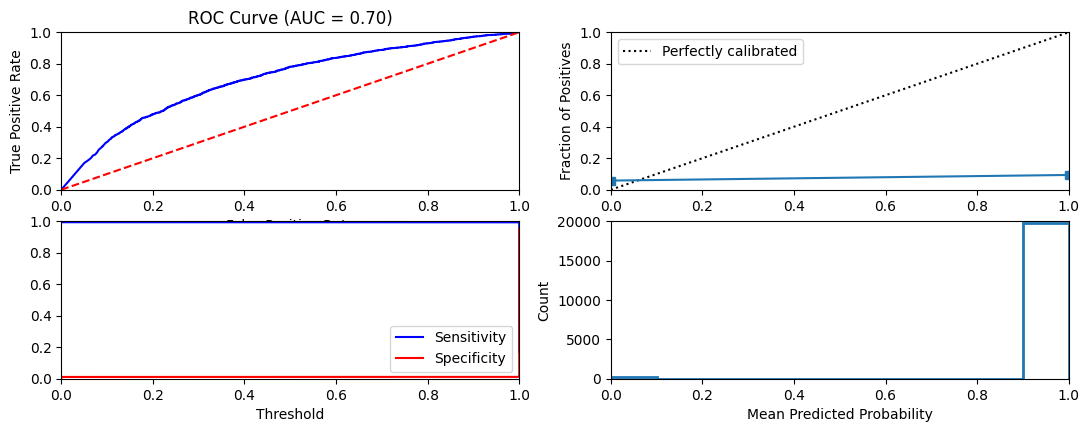


Similarity to LC grade ranking:  0.5509661412545291
Brier score: 0.8967994097912245
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.1511]


In [23]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict, model_name='Gaussian Naive Bayes')

### $l_1$ regularized logistic regression

  Model: L1 Regularized Logistic Regression
Fit time: 98.54 seconds
Optimal parameters:
{'C': 0.001}

Accuracy-maximizing threshold was: 1
Accuracy:  0.9067
              precision    recall  f1-score   support

  No default     0.9067    1.0000    0.9511     18134
     Default     0.0000    0.0000    0.0000      1866

    accuracy                         0.9067     20000
   macro avg     0.4533    0.5000    0.4755     20000
weighted avg     0.8221    0.9067    0.8623     20000



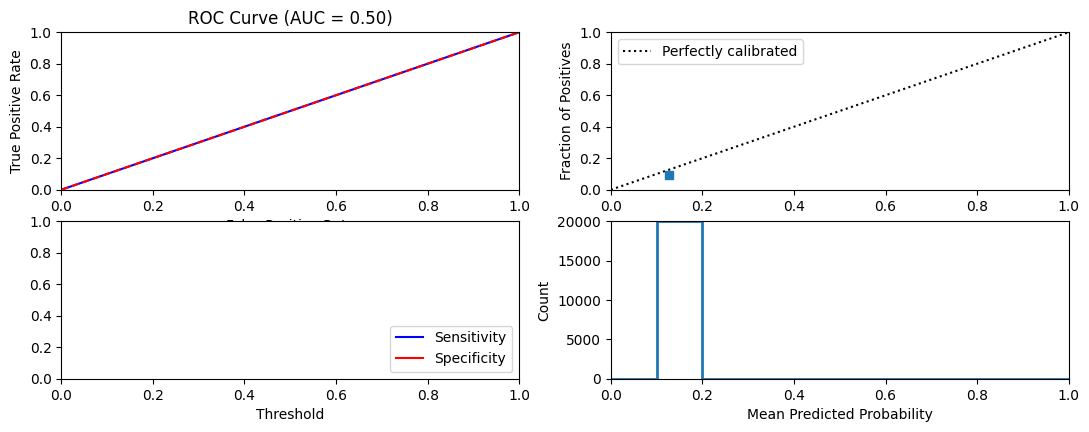


Similarity to LC grade ranking:  nan
Brier score: 0.0858000379974888
Were parameters on edge? : True
Score variations around CV search grid : 0.121502209131074
[0.90533333 0.90533333 0.90446667 0.90446667 0.9043     0.90423333]


In [24]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty='l1', solver='liblinear')
cv_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

l1_logistic = fit_classification(
    l1_logistic,
    data_dict,
    cv_parameters=cv_parameters,
    model_name="L1 Regularized Logistic Regression",
    random_state=default_seed
)

### $l_2$ regularized logistic regression

  Model: L2 Regularized Logistic Regression
Fit time: 3.5 seconds
Optimal parameters:
{'C': 0.001}

Accuracy-maximizing threshold was: 1
Accuracy:  0.9067
              precision    recall  f1-score   support

  No default     0.9067    1.0000    0.9511     18134
     Default     0.0000    0.0000    0.0000      1866

    accuracy                         0.9067     20000
   macro avg     0.4533    0.5000    0.4755     20000
weighted avg     0.8221    0.9067    0.8623     20000



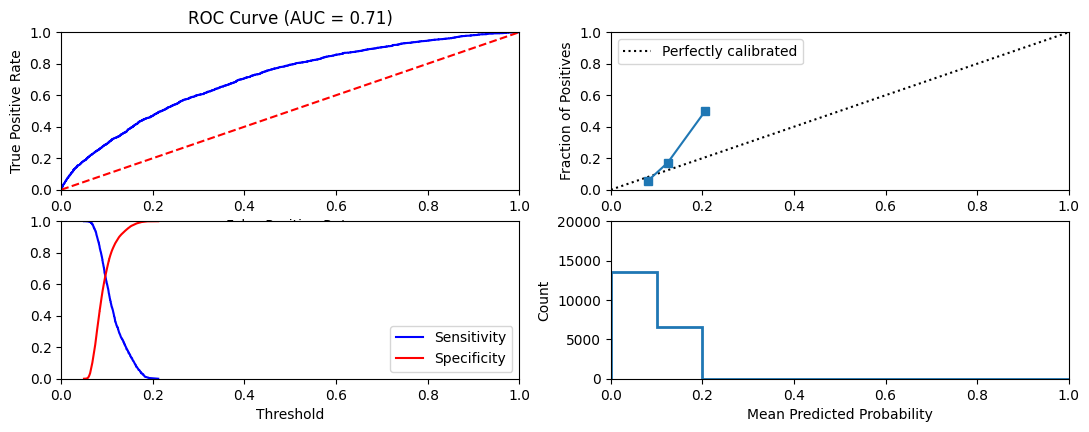


Similarity to LC grade ranking:  0.5333115106483931
Brier score: 0.08179815172571255
Were parameters on edge? : True
Score variations around CV search grid : 0.12150220913108625
[0.90533333 0.90526667 0.90453333 0.90463333 0.90433333 0.90423333]


In [25]:
## Train and test a l_1 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty='l2', solver='lbfgs')

cv_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

l2_logistic = fit_classification(
    l2_logistic,
    data_dict,
    cv_parameters=cv_parameters,
    model_name="L2 Regularized Logistic Regression",
    random_state=default_seed
)

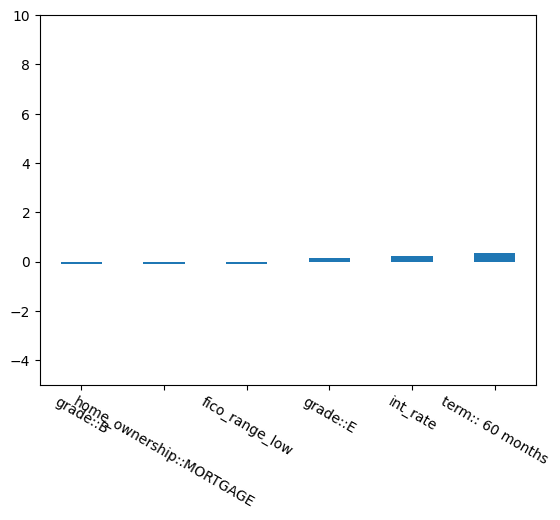

In [26]:
## plot top 3 features with the most positive (and negative) weights 
top_and_bottom_idx = list(np.argsort(l2_logistic['model'].coef_)[0,:3]) + list(np.argsort(l2_logistic['model'].coef_)[0,-3:])
bplot = pd.Series(l2_logistic['model'].coef_[0,top_and_bottom_idx])
xticks = selected_features[top_and_bottom_idx]
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-5,10))
p1.set_xticklabels(xticks)
plt.show()

### Decision tree

  Model: Decision Tree
Fit time: 10.94 seconds
Optimal parameters:
{'max_depth': 3, 'min_samples_split': 2}

Accuracy-maximizing threshold was: 0.7
Accuracy:  0.90685
              precision    recall  f1-score   support

  No default     0.9070    0.9998    0.9511     18134
     Default     0.6667    0.0032    0.0064      1866

    accuracy                         0.9069     20000
   macro avg     0.7868    0.5015    0.4788     20000
weighted avg     0.8845    0.9069    0.8630     20000



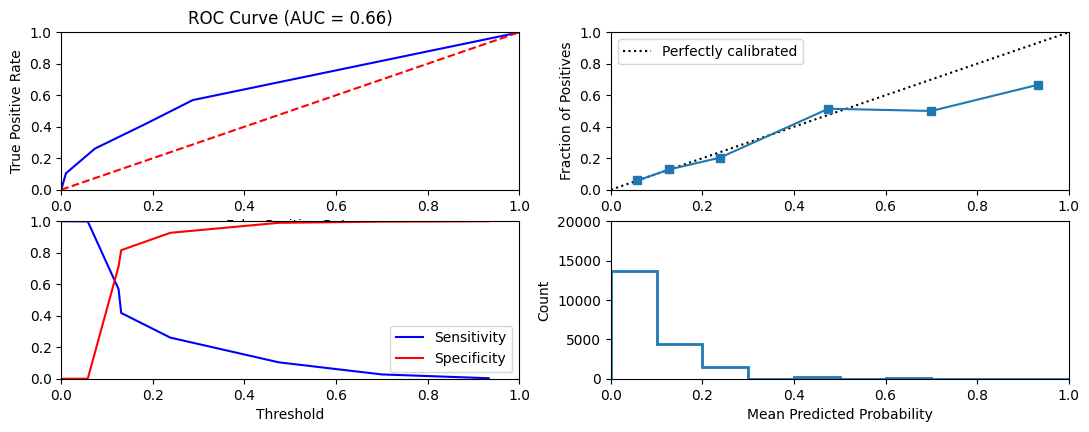


Similarity to LC grade ranking:  0.5827997189746716
Brier score: 0.07959010166923229
Were parameters on edge? : True
Score variations around CV search grid : 7.142067032926515
[0.90403333 0.90403333 0.90403333 0.8982     0.8982     0.8983
 0.86516667 0.86433333 0.86563333 0.83946667 0.84166667 0.84686667]


In [27]:
## Train and test a decision tree classifier

# Define the Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=default_seed)

# Define the cross-validation parameter grid
cv_parameters = {'max_depth': [3, 5, 10, 15], 'min_samples_split': [2, 5, 10]}

decision_tree = fit_classification(model=decision_tree, data_dict=data_dict,cv_parameters=cv_parameters, model_name="Decision Tree")

### Random forest

  Model: Random Forest
Fit time: 116.2 seconds
Optimal parameters:
{'max_depth': 15, 'n_estimators': 100}

Accuracy-maximizing threshold was: 0.2393948818707678
Accuracy:  0.88445
              precision    recall  f1-score   support

  No default     0.9246    0.9500    0.9371     18134
     Default     0.3372    0.2471    0.2852      1866

    accuracy                         0.8844     20000
   macro avg     0.6309    0.5985    0.6112     20000
weighted avg     0.8698    0.8844    0.8763     20000



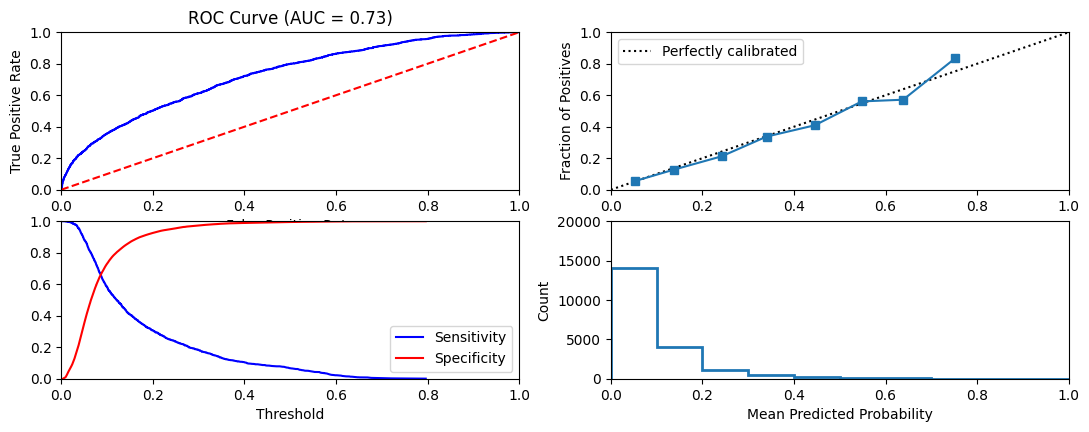


Similarity to LC grade ranking:  0.5625111398026428
Brier score: 0.07742218511022983
Were parameters on edge? : True
Score variations around CV search grid : 0.0626404804893258
[0.9044     0.9041     0.90406667 0.90433333 0.90463333 0.9044    ]


In [28]:
## Train and test a random forest classifier

# Define the Random Forest Classifier
random_forest = RandomForestClassifier(random_state=default_seed)

# Define the cross-validation parameter grid
cv_parameters = {'n_estimators': [100, 200], 'max_depth': [5, 10, 15]}

random_forest = fit_classification(model=random_forest, data_dict=data_dict,
                                           cv_parameters=cv_parameters, model_name="Random Forest")

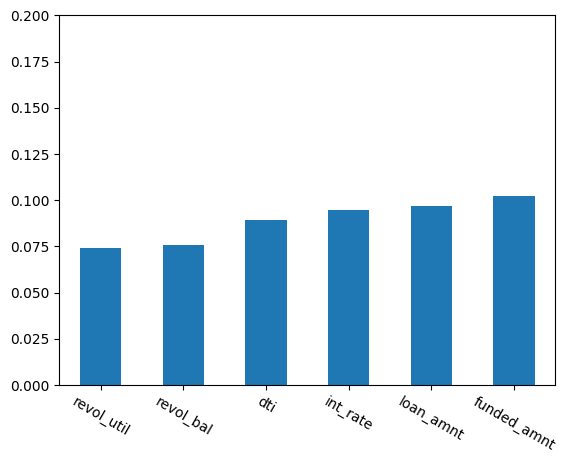

In [29]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

### Multi-layer perceptron

  Model: Multi-layer Perceptron
Fit time: 988.91 seconds
Optimal parameters:
{'activation': 'logistic', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'solver': 'adam'}

Accuracy-maximizing threshold was: 0.41422011618159826
Accuracy:  0.906
              precision    recall  f1-score   support

  No default     0.9094    0.9955    0.9505     18134
     Default     0.4527    0.0359    0.0665      1866

    accuracy                         0.9060     20000
   macro avg     0.6810    0.5157    0.5085     20000
weighted avg     0.8668    0.9060    0.8680     20000



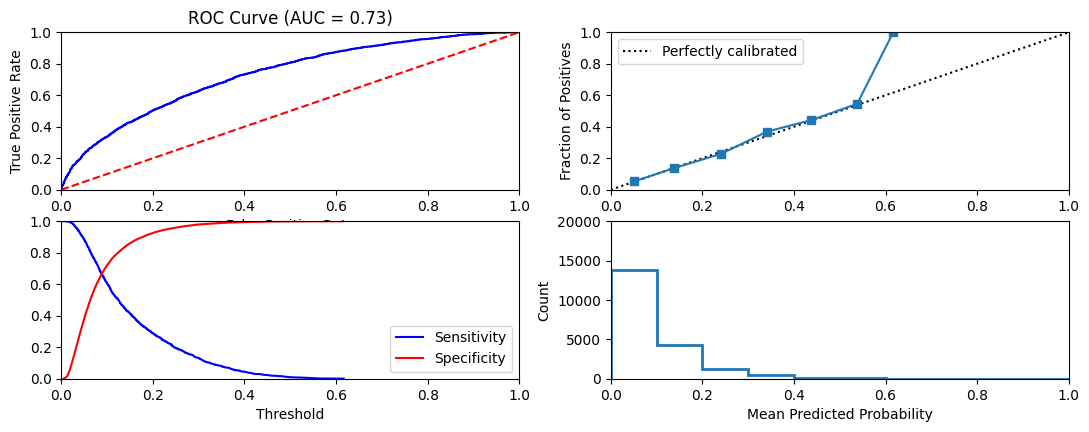


Similarity to LC grade ranking:  0.5756288616293189
Brier score: 0.07838377108790903
Were parameters on edge? : True
Score variations around CV search grid : 2.4317453299436296
[0.9046     0.9046     0.90426667 0.90433333 0.9047     0.90426667
 0.89653333 0.8989     0.8827     0.89923333 0.89906667 0.885     ]


In [30]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier(random_state=default_seed)
cv_parameters = {
    'hidden_layer_sizes': [(100,), (50,), (50, 25)],
    'activation': ['logistic', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.01],
}

mlp = fit_classification(mlp, data_dict, cv_parameters=cv_parameters, model_name='Multi-layer Perceptron')

## Train and Test logistic regression model with features derived by LendingClub

  Model: Logistic Regression with LendingClub Feature (Int Rate)
Fit time: 0.73 seconds
Optimal parameters:
{'C': 0.001}

Accuracy-maximizing threshold was: 1
Accuracy:  0.9067
              precision    recall  f1-score   support

  No default     0.9067    1.0000    0.9511     18134
     Default     0.0000    0.0000    0.0000      1866

    accuracy                         0.9067     20000
   macro avg     0.4533    0.5000    0.4755     20000
weighted avg     0.8221    0.9067    0.8623     20000



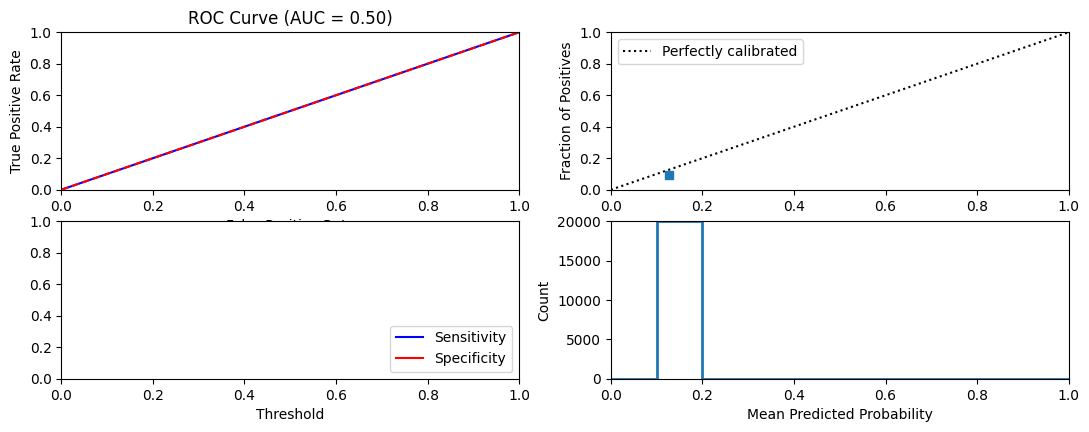


Similarity to LC grade ranking:  nan
Brier score: 0.08579925628506085
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.90533333 0.90533333 0.90533333 0.90533333 0.90533333 0.90533333]


In [31]:
## Find a lendingClub-defined feature and train a l1-regularized logistic regression model on data with only that feature
a_lendingclub_feature = ['dti']

data_dict = prepare_data(feature_subset = a_lendingclub_feature)
lc1_only_logistic = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)

cv_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

lc1_only_logistic = fit_classification(
    lc1_only_logistic,
    data_dict,
    cv_parameters=cv_parameters,
    model_name="Logistic Regression with LendingClub Feature (Int Rate)",
    random_state=default_seed
)

  Model: Logistic Regression with LendingClub Feature (Int Rate) - L2 Regularization
Fit time: 0.45 seconds
Optimal parameters:
{'C': 0.001}

Accuracy-maximizing threshold was: 1
Accuracy:  0.9067
              precision    recall  f1-score   support

  No default     0.9067    1.0000    0.9511     18134
     Default     0.0000    0.0000    0.0000      1866

    accuracy                         0.9067     20000
   macro avg     0.4533    0.5000    0.4755     20000
weighted avg     0.8221    0.9067    0.8623     20000



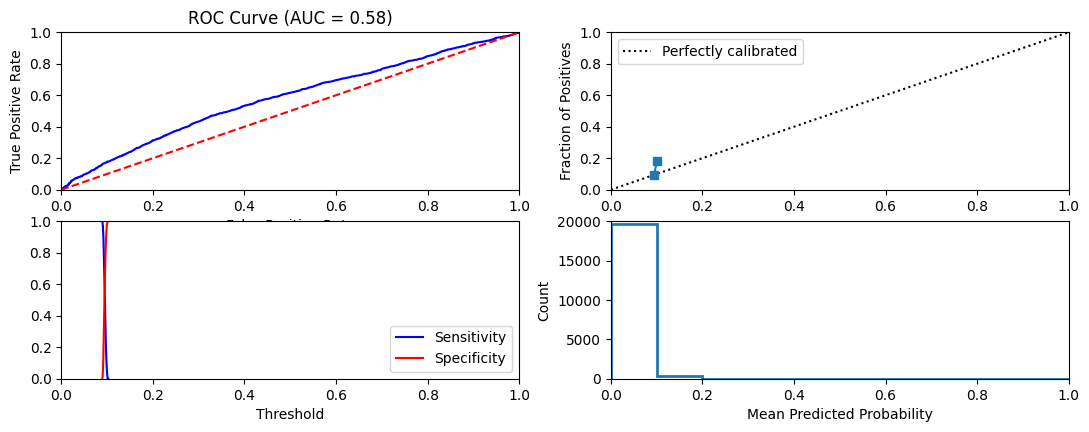


Similarity to LC grade ranking:  0.14182467627178275
Brier score: 0.08448117853633287
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.90533333 0.90533333 0.90533333 0.90533333 0.90533333 0.90533333]


In [32]:
## train a l2-regularized logistic regression model on data with only that feature
lc2_only_logistic = LogisticRegression(penalty='l2', solver='lbfgs', max_iter=1000)

cv_parameters = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}


lc2_only_logistic = fit_classification(
    lc2_only_logistic,
    data_dict,
    cv_parameters=cv_parameters,
    model_name="Logistic Regression with LendingClub Feature (Int Rate) - L2 Regularization",
    random_state=default_seed
)

## Train and test all the models you have tried previously after removing features derived by LendingClub 

In [269]:
from sklearn.metrics import roc_auc_score, accuracy_score, recall_score, precision_score, f1_score


In [251]:
your_features = ['loan_amnt', 'funded_amnt', 'int_rate', 'annual_inc']

In [252]:
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

  Model: Gaussian Naive Bayes
Fit time: 0.06 seconds
Optimal parameters:
{}

Accuracy-maximizing threshold was: 0.92812641989853
Accuracy:  0.90805
              precision    recall  f1-score   support

  No default     0.9128    0.9934    0.9514     18125
     Default     0.5657    0.0827    0.1443      1875

    accuracy                         0.9081     20000
   macro avg     0.7392    0.5381    0.5478     20000
weighted avg     0.8803    0.9081    0.8757     20000



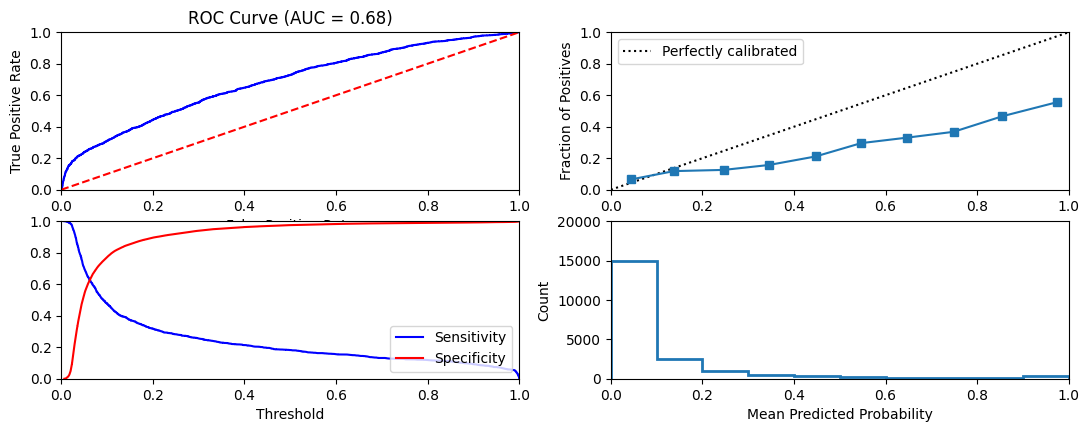


Similarity to LC grade ranking:  0.5067903999304733
Brier score: 0.08669523245040067
Were parameters on edge? : False
Score variations around CV search grid : 0.0
[0.89453333]


In [253]:
## Train and test a naive bayes classifier

gnb = GaussianNB()
gnb = fit_classification(gnb, data_dict, model_name='Gaussian Naive Bayes')

In [292]:
# running GB 100 times for robustness
auc = []
acc = []

d_recall = []
d_precision = []
d_f1 = []

nd_recall = []
nd_precision = []
nd_f1 = []

for i in range(0,100):
    np.random.seed(i)
    default_seed = i
    
    data['train'] = np.random.choice([True, False], size=len(data), p=[0.7, 0.3])
    X = np.concatenate( (X_continuous, X_discrete), axis = 1 )
    
    y = data.outcome.values
    
    train = data.train.values
    data_dict = prepare_data(feature_subset = your_features,random_state=i)

    all_features = pd.Series(continuous_features + discrete_features_dummies)
    idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                         if j.split("::")[0] in your_features]
    selected_features = all_features[idx]
    selected_features.reset_index(drop=True,inplace=True)
    gnb = GaussianNB()
    gnb = fit_classification(gnb, data_dict, model_name='Gaussian Naive Bayes', print_to_screen=False)
    auc.append(roc_auc_score(data_dict['y_test'], gnb['y_pred_probs']))
    acc.append(accuracy_score(data_dict['y_test'], gnb['y_pred_labels']))
    cr = classification_report(data_dict['y_test'], gnb['y_pred_labels'], target_names =['No default', 'Default'], digits = 4, output_dict=True)
    d_recall.append(cr['Default']['recall'])
    d_precision.append(cr['Default']['precision'])
    d_f1.append(cr['Default']['f1-score'])
    nd_recall.append(cr['No default']['precision'])
    nd_precision.append(cr['No default']['precision'])
    nd_f1.append(cr['No default']['precision'])


In [293]:
# mean and std-dev of 100 train test splits
print("Mean and std-dev of performance measures of Gaussian Naive Bayes 100 train test splits")
auc_array = np.array(auc)
acc_array = np.array(acc)
d_recall_array = np.array(d_recall)
d_precision_array = np.array(d_precision)
d_f1_array = np.array(d_f1)
nd_recall_array = np.array(nd_recall)
nd_precision_array = np.array(nd_precision)
nd_f1_array = np.array(nd_f1)

auc_mean, auc_std = np.mean(auc_array), np.std(auc_array)
acc_mean, acc_std = np.mean(acc_array), np.std(acc_array)
d_recall_mean, d_recall_std = np.mean(d_recall_array), np.std(d_recall_array)
d_precision_mean, d_precision_std = np.mean(d_precision_array), np.std(d_precision_array)
d_f1_mean, d_f1_std = np.mean(d_f1_array), np.std(d_f1_array)
nd_recall_mean, nd_recall_std = np.mean(nd_recall_array), np.std(nd_recall_array)
nd_precision_mean, nd_precision_std = np.mean(nd_precision_array), np.std(nd_precision_array)
nd_f1_mean, nd_f1_std = np.mean(nd_f1_array), np.std(nd_f1_array)

auc_result = "{:.4f} ± {:.4f}".format(auc_mean, auc_std)
acc_result = "{:.4f} ± {:.4f}".format(acc_mean, acc_std)
d_recall_result = "{:.4f} ± {:.4f}".format(d_recall_mean, d_recall_std)
d_precision_result = "{:.4f} ± {:.4f}".format(d_precision_mean, d_precision_std)
d_f1_result = "{:.4f} ± {:.4f}".format(d_f1_mean, d_f1_std)
nd_recall_result = "{:.4f} ± {:.4f}".format(nd_recall_mean, nd_recall_std)
nd_precision_result = "{:.4f} ± {:.4f}".format(nd_precision_mean, nd_precision_std)
nd_f1_result = "{:.4f} ± {:.4f}".format(nd_f1_mean, nd_f1_std)

print("AUC:", auc_result)
print("Accuracy:", acc_result)
print("Default Recall:", d_recall_result)
print("Default Precision:", d_precision_result)
print("Default F1-score:", d_f1_result)
print("Non-default Recall:", nd_recall_result)
print("Non-default Precision:", nd_precision_result)
print("Non-default F1-score:", nd_f1_result)

Mean and std-dev of performance measures of Gaussian Naive Bayes 100 train test splits
AUC: 0.6779 ± 0.0070
Accuracy: 0.9065 ± 0.0021
Default Recall: 0.0820 ± 0.0192
Default Precision: 0.5386 ± 0.0293
Default F1-score: 0.1414 ± 0.0294
Non-default Recall: 0.9119 ± 0.0027
Non-default Precision: 0.9119 ± 0.0027
Non-default F1-score: 0.9119 ± 0.0027


  Model: L1 Regularized Logistic Regression
Fit time: 15.95 seconds
Optimal parameters:
{'C': 0.001}

Accuracy-maximizing threshold was: 1
Accuracy:  0.90625
              precision    recall  f1-score   support

  No default     0.9062    1.0000    0.9508     18125
     Default     0.0000    0.0000    0.0000      1875

    accuracy                         0.9062     20000
   macro avg     0.4531    0.5000    0.4754     20000
weighted avg     0.8213    0.9062    0.8617     20000



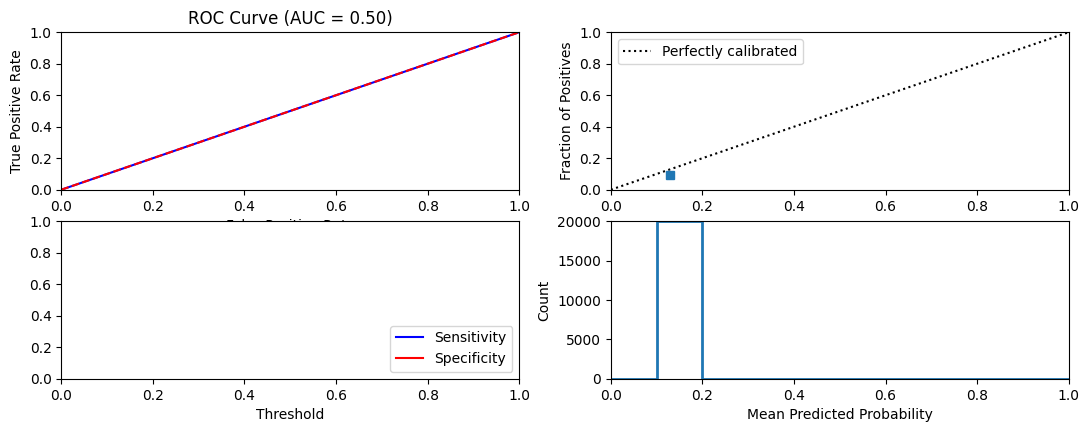


Similarity to LC grade ranking:  nan
Brier score: 0.08616413504815594
Were parameters on edge? : True
Score variations around CV search grid : 0.08472391056099804
[0.9049     0.9044     0.90413333 0.90413333]


In [255]:
## Train and test a l_1 regularized logistic regression classifier

l1_logistic = LogisticRegression(penalty='l1', solver='liblinear')
cv_parameters = {'C': [0.001, 0.1, 1, 10]}

l1_logistic = fit_classification(
    l1_logistic,
    data_dict,
    cv_parameters=cv_parameters,
    model_name="L1 Regularized Logistic Regression",
    random_state=default_seed
)

In [298]:
# running L1 100 times for robustness
auc = []
acc = []

d_recall = []
d_precision = []
d_f1 = []

nd_recall = []
nd_precision = []
nd_f1 = []

for i in range(0,100):
    np.random.seed(i)
    default_seed = i
    
    data['train'] = np.random.choice([True, False], size=len(data), p=[0.7, 0.3])
    X = np.concatenate( (X_continuous, X_discrete), axis = 1 )
    
    y = data.outcome.values
    
    train = data.train.values
    data_dict = prepare_data(feature_subset = your_features,random_state=i)

    all_features = pd.Series(continuous_features + discrete_features_dummies)
    idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                         if j.split("::")[0] in your_features]
    selected_features = all_features[idx]
    selected_features.reset_index(drop=True,inplace=True)
    l1_logistic = LogisticRegression(penalty='l1', solver='liblinear')
    cv_parameters = {'C': [0.001]} # choosing the best parameter from above
    
    l1_logistic = fit_classification(
        l1_logistic,
        data_dict,
        cv_parameters=cv_parameters,
        model_name="L1 Regularized Logistic Regression",
        random_state=default_seed,
        print_to_screen=False
    )
    auc.append(roc_auc_score(data_dict['y_test'], l1_logistic['y_pred_probs']))
    acc.append(accuracy_score(data_dict['y_test'], l1_logistic['y_pred_labels']))
    cr = classification_report(data_dict['y_test'], l1_logistic['y_pred_labels'], target_names =['No default', 'Default'], digits = 4, output_dict=True)
    d_recall.append(cr['Default']['recall'])
    d_precision.append(cr['Default']['precision'])
    d_f1.append(cr['Default']['f1-score'])
    nd_recall.append(cr['No default']['precision'])
    nd_precision.append(cr['No default']['precision'])
    nd_f1.append(cr['No default']['precision'])

In [299]:
# mean and std-dev of 100 train test splits
print("Mean and std-dev of performance measures of L1 100 train test splits")
auc_array = np.array(auc)
acc_array = np.array(acc)
d_recall_array = np.array(d_recall)
d_precision_array = np.array(d_precision)
d_f1_array = np.array(d_f1)
nd_recall_array = np.array(nd_recall)
nd_precision_array = np.array(nd_precision)
nd_f1_array = np.array(nd_f1)

auc_mean, auc_std = np.mean(auc_array), np.std(auc_array)
acc_mean, acc_std = np.mean(acc_array), np.std(acc_array)
d_recall_mean, d_recall_std = np.mean(d_recall_array), np.std(d_recall_array)
d_precision_mean, d_precision_std = np.mean(d_precision_array), np.std(d_precision_array)
d_f1_mean, d_f1_std = np.mean(d_f1_array), np.std(d_f1_array)
nd_recall_mean, nd_recall_std = np.mean(nd_recall_array), np.std(nd_recall_array)
nd_precision_mean, nd_precision_std = np.mean(nd_precision_array), np.std(nd_precision_array)
nd_f1_mean, nd_f1_std = np.mean(nd_f1_array), np.std(nd_f1_array)

auc_result = "{:.4f} ± {:.4f}".format(auc_mean, auc_std)
acc_result = "{:.4f} ± {:.4f}".format(acc_mean, acc_std)
d_recall_result = "{:.4f} ± {:.4f}".format(d_recall_mean, d_recall_std)
d_precision_result = "{:.4f} ± {:.4f}".format(d_precision_mean, d_precision_std)
d_f1_result = "{:.4f} ± {:.4f}".format(d_f1_mean, d_f1_std)
nd_recall_result = "{:.4f} ± {:.4f}".format(nd_recall_mean, nd_recall_std)
nd_precision_result = "{:.4f} ± {:.4f}".format(nd_precision_mean, nd_precision_std)
nd_f1_result = "{:.4f} ± {:.4f}".format(nd_f1_mean, nd_f1_std)

print("AUC:", auc_result)
print("Accuracy:", acc_result)
print("Default Recall:", d_recall_result)
print("Default Precision:", d_precision_result)
print("Default F1-score:", d_f1_result)
print("Non-default Recall:", nd_recall_result)
print("Non-default Precision:", nd_precision_result)
print("Non-default F1-score:", nd_f1_result)

Mean and std-dev of performance measures of L1 100 train test splits
AUC: 0.5000 ± 0.0000
Accuracy: 0.9054 ± 0.0020
Default Recall: 0.0000 ± 0.0000
Default Precision: 0.0000 ± 0.0000
Default F1-score: 0.0000 ± 0.0000
Non-default Recall: 0.9054 ± 0.0020
Non-default Precision: 0.9054 ± 0.0020
Non-default F1-score: 0.9054 ± 0.0020


  Model: L2 Regularized Logistic Regression
Fit time: 0.39 seconds
Optimal parameters:
{'C': 0.001}

Accuracy-maximizing threshold was: 0.12003279294371896
Accuracy:  0.90855
              precision    recall  f1-score   support

  No default     0.9110    0.9967    0.9519     18163
     Default     0.5312    0.0370    0.0692      1837

    accuracy                         0.9085     20000
   macro avg     0.7211    0.5169    0.5106     20000
weighted avg     0.8761    0.9085    0.8708     20000



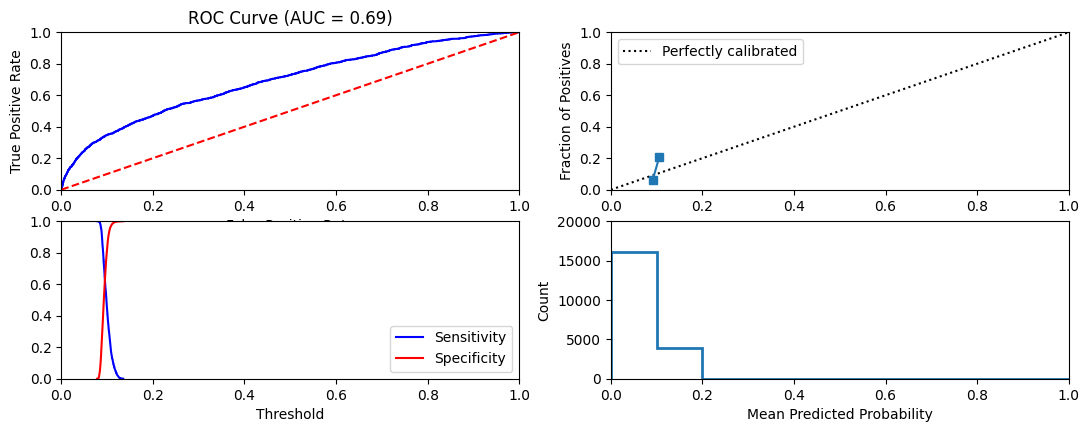


Similarity to LC grade ranking:  0.4417814893703114
Brier score: 0.08245499037474942
Were parameters on edge? : True
Score variations around CV search grid : 0.11041589988957194
[0.90566667 0.90526667 0.90476667 0.90466667]


In [300]:
## Train and test a l_2 regularized logistic regression classifier

l2_logistic = LogisticRegression(penalty='l2', solver='lbfgs')

cv_parameters = {'C': [0.001, 0.1, 1, 10]}

l2_logistic = fit_classification(
    l2_logistic,
    data_dict,
    cv_parameters=cv_parameters,
    model_name="L2 Regularized Logistic Regression",
    random_state=default_seed
)

In [296]:
# running L2 100 times for robustness
auc = []
acc = []

d_recall = []
d_precision = []
d_f1 = []

nd_recall = []
nd_precision = []
nd_f1 = []

for i in range(0,100):
    np.random.seed(i)
    default_seed = i
    
    data['train'] = np.random.choice([True, False], size=len(data), p=[0.7, 0.3])
    X = np.concatenate( (X_continuous, X_discrete), axis = 1 )
    
    y = data.outcome.values
    
    train = data.train.values
    data_dict = prepare_data(feature_subset = your_features,random_state=i)

    all_features = pd.Series(continuous_features + discrete_features_dummies)
    idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                         if j.split("::")[0] in your_features]
    selected_features = all_features[idx]
    selected_features.reset_index(drop=True,inplace=True)
    l2_logistic = LogisticRegression(penalty='l2', solver='lbfgs')

    cv_parameters = {'C': [0.001]} # as it is the optimal parameter as shown above
    
    l2_logistic = fit_classification(
        l2_logistic,
        data_dict,
        cv_parameters=cv_parameters,
        model_name="L2 Regularized Logistic Regression",
        random_state=default_seed,
        print_to_screen=False
    )
    auc.append(roc_auc_score(data_dict['y_test'], l2_logistic['y_pred_probs']))
    acc.append(accuracy_score(data_dict['y_test'], l2_logistic['y_pred_labels']))
    cr = classification_report(data_dict['y_test'], l2_logistic['y_pred_labels'], target_names =['No default', 'Default'], digits = 4, output_dict=True)
    d_recall.append(cr['Default']['recall'])
    d_precision.append(cr['Default']['precision'])
    d_f1.append(cr['Default']['f1-score'])
    nd_recall.append(cr['No default']['precision'])
    nd_precision.append(cr['No default']['precision'])
    nd_f1.append(cr['No default']['precision'])


In [297]:
# mean and std-dev of 100 train test splits
print("Mean and std-dev of performance measures of L2 100 train test splits")
auc_array = np.array(auc)
acc_array = np.array(acc)
d_recall_array = np.array(d_recall)
d_precision_array = np.array(d_precision)
d_f1_array = np.array(d_f1)
nd_recall_array = np.array(nd_recall)
nd_precision_array = np.array(nd_precision)
nd_f1_array = np.array(nd_f1)

auc_mean, auc_std = np.mean(auc_array), np.std(auc_array)
acc_mean, acc_std = np.mean(acc_array), np.std(acc_array)
d_recall_mean, d_recall_std = np.mean(d_recall_array), np.std(d_recall_array)
d_precision_mean, d_precision_std = np.mean(d_precision_array), np.std(d_precision_array)
d_f1_mean, d_f1_std = np.mean(d_f1_array), np.std(d_f1_array)
nd_recall_mean, nd_recall_std = np.mean(nd_recall_array), np.std(nd_recall_array)
nd_precision_mean, nd_precision_std = np.mean(nd_precision_array), np.std(nd_precision_array)
nd_f1_mean, nd_f1_std = np.mean(nd_f1_array), np.std(nd_f1_array)

auc_result = "{:.4f} ± {:.4f}".format(auc_mean, auc_std)
acc_result = "{:.4f} ± {:.4f}".format(acc_mean, acc_std)
d_recall_result = "{:.4f} ± {:.4f}".format(d_recall_mean, d_recall_std)
d_precision_result = "{:.4f} ± {:.4f}".format(d_precision_mean, d_precision_std)
d_f1_result = "{:.4f} ± {:.4f}".format(d_f1_mean, d_f1_std)
nd_recall_result = "{:.4f} ± {:.4f}".format(nd_recall_mean, nd_recall_std)
nd_precision_result = "{:.4f} ± {:.4f}".format(nd_precision_mean, nd_precision_std)
nd_f1_result = "{:.4f} ± {:.4f}".format(nd_f1_mean, nd_f1_std)

print("AUC:", auc_result)
print("Accuracy:", acc_result)
print("Default Recall:", d_recall_result)
print("Default Precision:", d_precision_result)
print("Default F1-score:", d_f1_result)
print("Non-default Recall:", nd_recall_result)
print("Non-default Precision:", nd_precision_result)
print("Non-default F1-score:", nd_f1_result)

Mean and std-dev of performance measures of L2 100 train test splits
AUC: 0.6843 ± 0.0075
Accuracy: 0.9056 ± 0.0020
Default Recall: 0.0361 ± 0.0199
Default Precision: 0.5181 ± 0.0701
Default F1-score: 0.0661 ± 0.0337
Non-default Recall: 0.9082 ± 0.0027
Non-default Precision: 0.9082 ± 0.0027
Non-default F1-score: 0.9082 ± 0.0027


  Model: Decision Tree
Fit time: 1.19 seconds
Optimal parameters:
{'max_depth': 3, 'min_samples_split': 2}

Accuracy-maximizing threshold was: 0.5879629629629629
Accuracy:  0.90815
              precision    recall  f1-score   support

  No default     0.9082    1.0000    0.9519     18163
     Default     0.0000    0.0000    0.0000      1837

    accuracy                         0.9082     20000
   macro avg     0.4541    0.5000    0.4759     20000
weighted avg     0.8247    0.9082    0.8644     20000



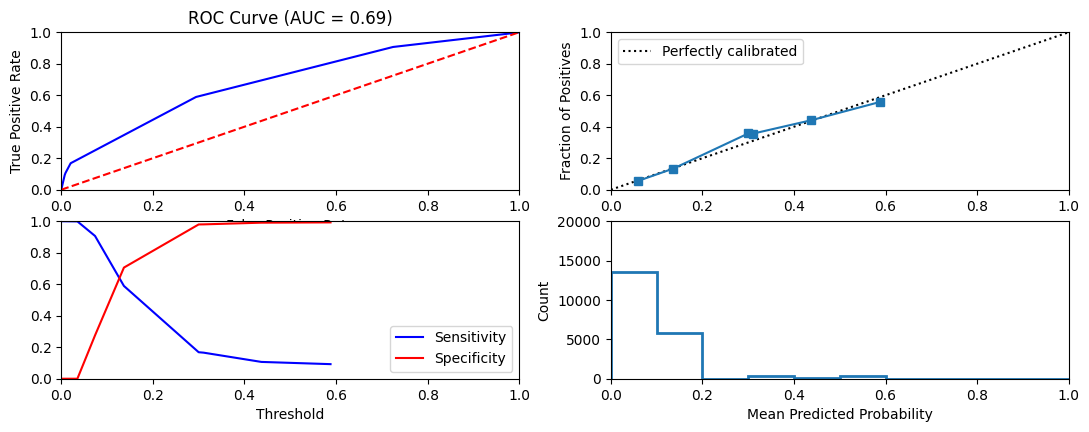


Similarity to LC grade ranking:  0.8313699235546639
Brier score: 0.07708212354292732
Were parameters on edge? : True
Score variations around CV search grid : 3.6017494211474093
[0.90696667 0.90696667 0.90153333 0.90153333 0.8743     0.87513333]


In [301]:
## Train and test a decision tree classifier

# Define the Decision Tree Classifier
decision_tree = DecisionTreeClassifier(random_state=default_seed)

# Define the cross-validation parameter grid
cv_parameters = {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5]}

decision_tree = fit_classification(model=decision_tree, data_dict=data_dict,cv_parameters=cv_parameters, model_name="Decision Tree")

In [304]:
# running Decision Tree 100 times for robustness
auc = []
acc = []

d_recall = []
d_precision = []
d_f1 = []

nd_recall = []
nd_precision = []
nd_f1 = []

for i in range(0,100):
    np.random.seed(i)
    default_seed = i
    
    data['train'] = np.random.choice([True, False], size=len(data), p=[0.7, 0.3])
    X = np.concatenate( (X_continuous, X_discrete), axis = 1 )
    
    y = data.outcome.values
    
    train = data.train.values
    data_dict = prepare_data(feature_subset = your_features,random_state=i)

    all_features = pd.Series(continuous_features + discrete_features_dummies)
    idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                         if j.split("::")[0] in your_features]
    selected_features = all_features[idx]
    selected_features.reset_index(drop=True,inplace=True)
    decision_tree = DecisionTreeClassifier(random_state=default_seed)

    cv_parameters = {'max_depth': [3], 'min_samples_split': [2]} # choosing the best parameters from above
    
    decision_tree = fit_classification(model=decision_tree, data_dict=data_dict,cv_parameters=cv_parameters, model_name="Decision Tree",print_to_screen=False)
    auc.append(roc_auc_score(data_dict['y_test'], decision_tree['y_pred_probs']))
    acc.append(accuracy_score(data_dict['y_test'], decision_tree['y_pred_labels']))
    cr = classification_report(data_dict['y_test'], decision_tree['y_pred_labels'], target_names =['No default', 'Default'], digits = 4, output_dict=True)
    d_recall.append(cr['Default']['recall'])
    d_precision.append(cr['Default']['precision'])
    d_f1.append(cr['Default']['f1-score'])
    nd_recall.append(cr['No default']['precision'])
    nd_precision.append(cr['No default']['precision'])
    nd_f1.append(cr['No default']['precision'])


In [305]:
# mean and std-dev of 100 train test splits
print("Mean and std-dev of performance measures of Decision Tree 100 train test splits")
auc_array = np.array(auc)
acc_array = np.array(acc)
d_recall_array = np.array(d_recall)
d_precision_array = np.array(d_precision)
d_f1_array = np.array(d_f1)
nd_recall_array = np.array(nd_recall)
nd_precision_array = np.array(nd_precision)
nd_f1_array = np.array(nd_f1)

auc_mean, auc_std = np.mean(auc_array), np.std(auc_array)
acc_mean, acc_std = np.mean(acc_array), np.std(acc_array)
d_recall_mean, d_recall_std = np.mean(d_recall_array), np.std(d_recall_array)
d_precision_mean, d_precision_std = np.mean(d_precision_array), np.std(d_precision_array)
d_f1_mean, d_f1_std = np.mean(d_f1_array), np.std(d_f1_array)
nd_recall_mean, nd_recall_std = np.mean(nd_recall_array), np.std(nd_recall_array)
nd_precision_mean, nd_precision_std = np.mean(nd_precision_array), np.std(nd_precision_array)
nd_f1_mean, nd_f1_std = np.mean(nd_f1_array), np.std(nd_f1_array)

auc_result = "{:.4f} ± {:.4f}".format(auc_mean, auc_std)
acc_result = "{:.4f} ± {:.4f}".format(acc_mean, acc_std)
d_recall_result = "{:.4f} ± {:.4f}".format(d_recall_mean, d_recall_std)
d_precision_result = "{:.4f} ± {:.4f}".format(d_precision_mean, d_precision_std)
d_f1_result = "{:.4f} ± {:.4f}".format(d_f1_mean, d_f1_std)
nd_recall_result = "{:.4f} ± {:.4f}".format(nd_recall_mean, nd_recall_std)
nd_precision_result = "{:.4f} ± {:.4f}".format(nd_precision_mean, nd_precision_std)
nd_f1_result = "{:.4f} ± {:.4f}".format(nd_f1_mean, nd_f1_std)

print("AUC:", auc_result)
print("Accuracy:", acc_result)
print("Default Recall:", d_recall_result)
print("Default Precision:", d_precision_result)
print("Default F1-score:", d_f1_result)
print("Non-default Recall:", nd_recall_result)
print("Non-default Precision:", nd_precision_result)
print("Non-default F1-score:", nd_f1_result)

Mean and std-dev of performance measures of Decision Tree 100 train test splits
AUC: 0.6800 ± 0.0065
Accuracy: 0.9060 ± 0.0022
Default Recall: 0.0240 ± 0.0271
Default Precision: 0.3817 ± 0.2653
Default F1-score: 0.0440 ± 0.0483
Non-default Recall: 0.9073 ± 0.0030
Non-default Precision: 0.9073 ± 0.0030
Non-default F1-score: 0.9073 ± 0.0030


  Model: Random Forest
Fit time: 27.7 seconds
Optimal parameters:
{'max_depth': 5, 'n_estimators': 50}

Accuracy-maximizing threshold was: 0.5094694713245991
Accuracy:  0.90885
              precision    recall  f1-score   support

  No default     0.9122    0.9952    0.9519     18125
     Default     0.6150    0.0741    0.1323      1875

    accuracy                         0.9089     20000
   macro avg     0.7636    0.5347    0.5421     20000
weighted avg     0.8843    0.9089    0.8751     20000



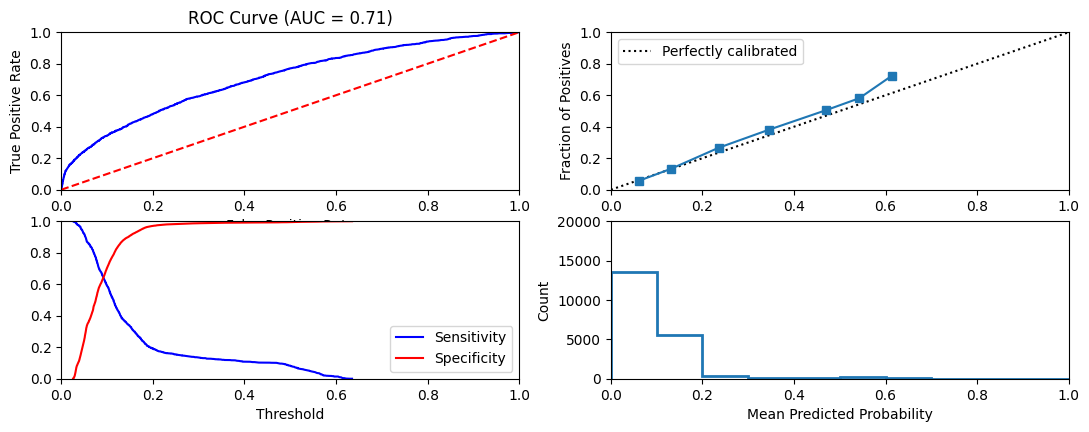


Similarity to LC grade ranking:  0.7209809105307838
Brier score: 0.07779928385733174
Were parameters on edge? : True
Score variations around CV search grid : 0.5056843348590048
[0.90306667 0.90306667 0.89906667 0.8985    ]


In [261]:
## Train and test a random forest classifier

# Define the Random Forest Classifier
random_forest = RandomForestClassifier(random_state=default_seed)

# Define the cross-validation parameter grid
cv_parameters = {'n_estimators': [50, 100], 'max_depth': [5, 10]}

random_forest = fit_classification(model=random_forest, data_dict=data_dict,
                                           cv_parameters=cv_parameters, model_name="Random Forest")

In [307]:
# running Random Forest 100 times for robustness
auc = []
acc = []

d_recall = []
d_precision = []
d_f1 = []

nd_recall = []
nd_precision = []
nd_f1 = []

for i in range(0,100):
    np.random.seed(i)
    default_seed = i
    
    data['train'] = np.random.choice([True, False], size=len(data), p=[0.7, 0.3])
    X = np.concatenate( (X_continuous, X_discrete), axis = 1 )
    
    y = data.outcome.values
    
    train = data.train.values
    data_dict = prepare_data(feature_subset = your_features,random_state=i)

    all_features = pd.Series(continuous_features + discrete_features_dummies)
    idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                         if j.split("::")[0] in your_features]
    selected_features = all_features[idx]
    selected_features.reset_index(drop=True,inplace=True)
    random_forest = RandomForestClassifier(random_state=default_seed)

    cv_parameters = {'n_estimators': [50], 'max_depth': [5]} # choosing best parameters from above
    
    random_forest = fit_classification(model=random_forest, data_dict=data_dict,
                                           cv_parameters=cv_parameters, model_name="Random Forest", print_to_screen=False)
    auc.append(roc_auc_score(data_dict['y_test'], random_forest['y_pred_probs']))
    acc.append(accuracy_score(data_dict['y_test'], random_forest['y_pred_labels']))
    cr = classification_report(data_dict['y_test'], random_forest['y_pred_labels'], target_names =['No default', 'Default'], digits = 4, output_dict=True)
    d_recall.append(cr['Default']['recall'])
    d_precision.append(cr['Default']['precision'])
    d_f1.append(cr['Default']['f1-score'])
    nd_recall.append(cr['No default']['precision'])
    nd_precision.append(cr['No default']['precision'])
    nd_f1.append(cr['No default']['precision'])


In [308]:
# mean and std-dev of 100 train test splits
print("Mean and std-dev of performance measures of Random Forest 100 train test splits")
auc_array = np.array(auc)
acc_array = np.array(acc)
d_recall_array = np.array(d_recall)
d_precision_array = np.array(d_precision)
d_f1_array = np.array(d_f1)
nd_recall_array = np.array(nd_recall)
nd_precision_array = np.array(nd_precision)
nd_f1_array = np.array(nd_f1)

auc_mean, auc_std = np.mean(auc_array), np.std(auc_array)
acc_mean, acc_std = np.mean(acc_array), np.std(acc_array)
d_recall_mean, d_recall_std = np.mean(d_recall_array), np.std(d_recall_array)
d_precision_mean, d_precision_std = np.mean(d_precision_array), np.std(d_precision_array)
d_f1_mean, d_f1_std = np.mean(d_f1_array), np.std(d_f1_array)
nd_recall_mean, nd_recall_std = np.mean(nd_recall_array), np.std(nd_recall_array)
nd_precision_mean, nd_precision_std = np.mean(nd_precision_array), np.std(nd_precision_array)
nd_f1_mean, nd_f1_std = np.mean(nd_f1_array), np.std(nd_f1_array)

auc_result = "{:.4f} ± {:.4f}".format(auc_mean, auc_std)
acc_result = "{:.4f} ± {:.4f}".format(acc_mean, acc_std)
d_recall_result = "{:.4f} ± {:.4f}".format(d_recall_mean, d_recall_std)
d_precision_result = "{:.4f} ± {:.4f}".format(d_precision_mean, d_precision_std)
d_f1_result = "{:.4f} ± {:.4f}".format(d_f1_mean, d_f1_std)
nd_recall_result = "{:.4f} ± {:.4f}".format(nd_recall_mean, nd_recall_std)
nd_precision_result = "{:.4f} ± {:.4f}".format(nd_precision_mean, nd_precision_std)
nd_f1_result = "{:.4f} ± {:.4f}".format(nd_f1_mean, nd_f1_std)

print("AUC:", auc_result)
print("Accuracy:", acc_result)
print("Default Recall:", d_recall_result)
print("Default Precision:", d_precision_result)
print("Default F1-score:", d_f1_result)
print("Non-default Recall:", nd_recall_result)
print("Non-default Precision:", nd_precision_result)
print("Non-default F1-score:", nd_f1_result)

Mean and std-dev of performance measures of Random Forest 100 train test splits
AUC: 0.7117 ± 0.0064
Accuracy: 0.9073 ± 0.0022
Default Recall: 0.0723 ± 0.0124
Default Precision: 0.5784 ± 0.0339
Default F1-score: 0.1281 ± 0.0197
Non-default Recall: 0.9112 ± 0.0023
Non-default Precision: 0.9112 ± 0.0023
Non-default F1-score: 0.9112 ± 0.0023


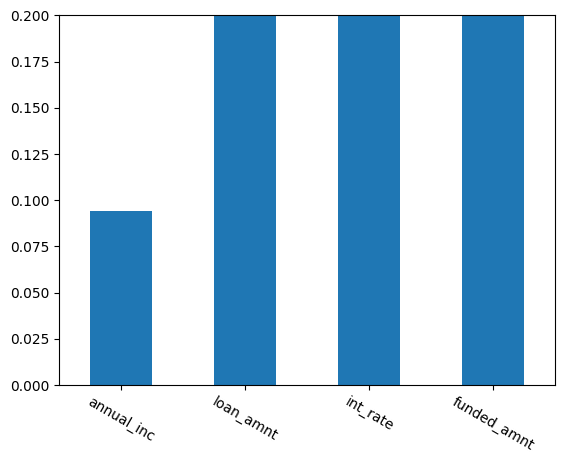

In [262]:
## Plot top 6 most significant features
top_idx = list(np.argsort(random_forest['model'].feature_importances_)[-6:]) 
bplot = pd.Series(random_forest['model'].feature_importances_[top_idx])
xticks = selected_features[top_idx]
p2 = bplot.plot(kind='bar',rot=-30,ylim=(0,0.2))
p2.set_xticklabels(xticks)
plt.show()

  Model: Multi-layer Perceptron
Fit time: 136.4 seconds
Optimal parameters:
{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50, 25), 'solver': 'adam'}

Accuracy-maximizing threshold was: 0.4197309983743021
Accuracy:  0.909
              precision    recall  f1-score   support

  No default     0.9142    0.9928    0.9519     18125
     Default     0.5868    0.0992    0.1697      1875

    accuracy                         0.9090     20000
   macro avg     0.7505    0.5460    0.5608     20000
weighted avg     0.8835    0.9090    0.8785     20000



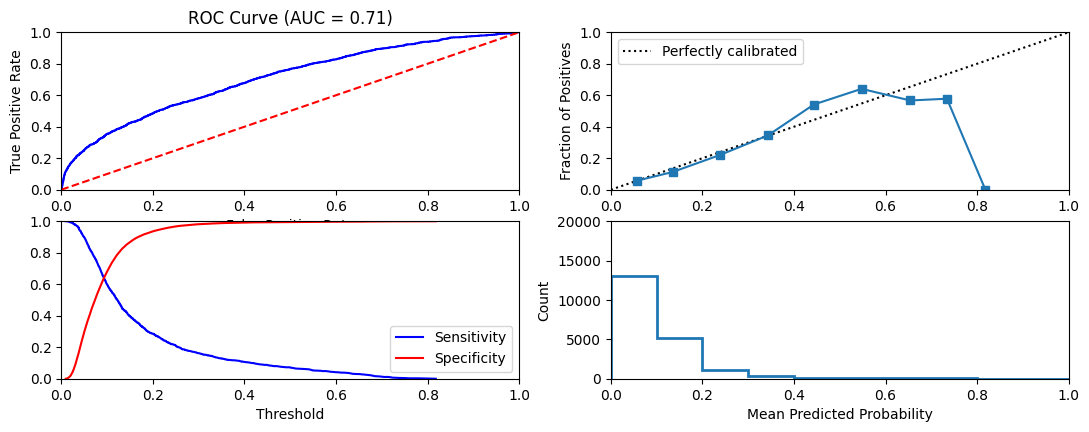


Similarity to LC grade ranking:  0.6373968954042396
Brier score: 0.07801128703928711
Were parameters on edge? : True
Score variations around CV search grid : 0.040535062829330656
[0.9042     0.90423333 0.90426667 0.90456667]


In [263]:
## Train and test a multi-layer perceptron classifier

mlp = MLPClassifier(random_state=default_seed)
cv_parameters = {
    'hidden_layer_sizes': [(100,), (50, 25)],
    'activation': ['logistic', 'relu'],
    'solver': ['adam'],
    'alpha': [ 0.01],
}

mlp = fit_classification(mlp, data_dict, cv_parameters=cv_parameters, model_name='Multi-layer Perceptron')

In [309]:
# running mlp 100 times for robustness
auc = []
acc = []

d_recall = []
d_precision = []
d_f1 = []

nd_recall = []
nd_precision = []
nd_f1 = []

for i in range(0,100):
    np.random.seed(i)
    default_seed = i
    
    data['train'] = np.random.choice([True, False], size=len(data), p=[0.7, 0.3])
    X = np.concatenate( (X_continuous, X_discrete), axis = 1 )
    
    y = data.outcome.values
    
    train = data.train.values
    data_dict = prepare_data(feature_subset = your_features,random_state=i)

    all_features = pd.Series(continuous_features + discrete_features_dummies)
    idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                         if j.split("::")[0] in your_features]
    selected_features = all_features[idx]
    selected_features.reset_index(drop=True,inplace=True)
    mlp = MLPClassifier(random_state=default_seed)
    cv_parameters = {
        'hidden_layer_sizes': [(50, 25)],
        'activation': ['relu'],
        'solver': ['adam'],
        'alpha': [ 0.01],
    }                                      # choosing the best paramters from above
    
    mlp = fit_classification(mlp, data_dict, cv_parameters=cv_parameters, model_name='Multi-layer Perceptron',print_to_screen=False)
    auc.append(roc_auc_score(data_dict['y_test'], mlp['y_pred_probs']))
    acc.append(accuracy_score(data_dict['y_test'], mlp['y_pred_labels']))
    cr = classification_report(data_dict['y_test'], mlp['y_pred_labels'], target_names =['No default', 'Default'], digits = 4, output_dict=True)
    d_recall.append(cr['Default']['recall'])
    d_precision.append(cr['Default']['precision'])
    d_f1.append(cr['Default']['f1-score'])
    nd_recall.append(cr['No default']['precision'])
    nd_precision.append(cr['No default']['precision'])
    nd_f1.append(cr['No default']['precision'])


In [310]:
# mean and std-dev of 100 train test splits
print("Mean and std-dev of performance measures of MLP 100 train test splits")
auc_array = np.array(auc)
acc_array = np.array(acc)
d_recall_array = np.array(d_recall)
d_precision_array = np.array(d_precision)
d_f1_array = np.array(d_f1)
nd_recall_array = np.array(nd_recall)
nd_precision_array = np.array(nd_precision)
nd_f1_array = np.array(nd_f1)

auc_mean, auc_std = np.mean(auc_array), np.std(auc_array)
acc_mean, acc_std = np.mean(acc_array), np.std(acc_array)
d_recall_mean, d_recall_std = np.mean(d_recall_array), np.std(d_recall_array)
d_precision_mean, d_precision_std = np.mean(d_precision_array), np.std(d_precision_array)
d_f1_mean, d_f1_std = np.mean(d_f1_array), np.std(d_f1_array)
nd_recall_mean, nd_recall_std = np.mean(nd_recall_array), np.std(nd_recall_array)
nd_precision_mean, nd_precision_std = np.mean(nd_precision_array), np.std(nd_precision_array)
nd_f1_mean, nd_f1_std = np.mean(nd_f1_array), np.std(nd_f1_array)

auc_result = "{:.4f} ± {:.4f}".format(auc_mean, auc_std)
acc_result = "{:.4f} ± {:.4f}".format(acc_mean, acc_std)
d_recall_result = "{:.4f} ± {:.4f}".format(d_recall_mean, d_recall_std)
d_precision_result = "{:.4f} ± {:.4f}".format(d_precision_mean, d_precision_std)
d_f1_result = "{:.4f} ± {:.4f}".format(d_f1_mean, d_f1_std)
nd_recall_result = "{:.4f} ± {:.4f}".format(nd_recall_mean, nd_recall_std)
nd_precision_result = "{:.4f} ± {:.4f}".format(nd_precision_mean, nd_precision_std)
nd_f1_result = "{:.4f} ± {:.4f}".format(nd_f1_mean, nd_f1_std)

print("AUC:", auc_result)
print("Accuracy:", acc_result)
print("Default Recall:", d_recall_result)
print("Default Precision:", d_precision_result)
print("Default F1-score:", d_f1_result)
print("Non-default Recall:", nd_recall_result)
print("Non-default Precision:", nd_precision_result)
print("Non-default F1-score:", nd_f1_result)

Mean and std-dev of performance measures of MLP 100 train test splits
AUC: 0.7116 ± 0.0065
Accuracy: 0.9069 ± 0.0020
Default Recall: 0.0843 ± 0.0136
Default Precision: 0.5506 ± 0.0270
Default F1-score: 0.1457 ± 0.0209
Non-default Recall: 0.9121 ± 0.0022
Non-default Precision: 0.9121 ± 0.0022
Non-default F1-score: 0.9121 ± 0.0022


## Time stability test of YOURMODEL

  Model: Multi-layer Perceptron
Fit time: 215.62 seconds
Optimal parameters:
{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'solver': 'adam'}

Accuracy-maximizing threshold was: 0.06844371209655108
Accuracy:  0.8921428571428571
              precision    recall  f1-score   support

  No default     0.8940    0.9976    0.9430      6255
     Default     0.2500    0.0067    0.0131       745

    accuracy                         0.8921      7000
   macro avg     0.5720    0.5022    0.4780      7000
weighted avg     0.8254    0.8921    0.8440      7000



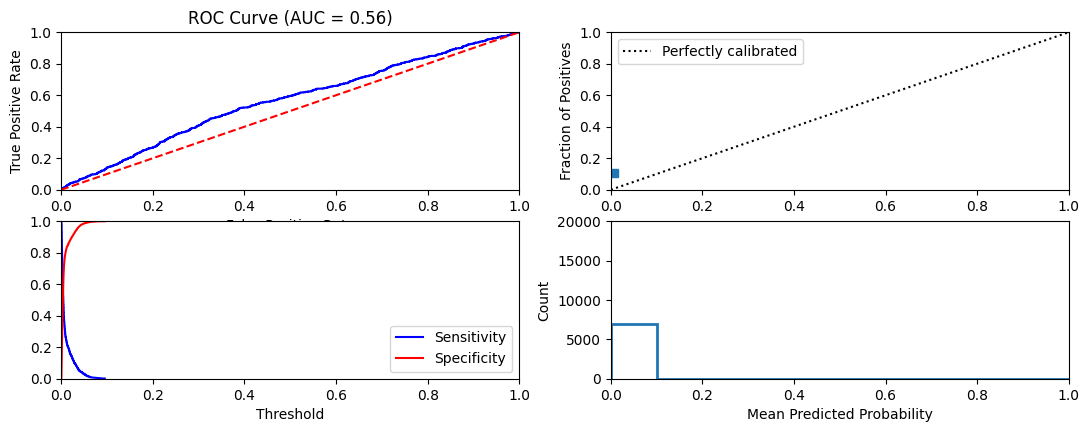


Similarity to LC grade ranking:  0.20901553708483656
Brier score: 0.10450648375866925
Were parameters on edge? : True
Score variations around CV search grid : 0.2010050251256172
[0.995      0.995      0.995      0.995      0.995      0.995
 0.99466667 0.995      0.993      0.99477778 0.995      0.99411111]


In [55]:
## Define the time window of your train and test data
start_date_train = pd.to_datetime('2012-01-01')
end_date_train = pd.to_datetime('2012-12-31')
start_date_test = pd.to_datetime('2017-01-01')
end_date_test = pd.to_datetime('2017-12-31')

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
mlp = MLPClassifier(random_state=default_seed)
cv_parameters = {
    'hidden_layer_sizes': [(100,), (50,), (50, 25)],
    'activation': ['logistic', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.01],
}

mlp = fit_classification(mlp, data_dict_test, cv_parameters=cv_parameters, model_name='Multi-layer Perceptron')

  Model: Multi-layer Perceptron
Fit time: 310.55 seconds
Optimal parameters:
{'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (50,), 'solver': 'adam'}

Accuracy-maximizing threshold was: 0.5183739463710471
Accuracy:  0.8851428571428571
              precision    recall  f1-score   support

  No default     0.8996    0.9812    0.9386      6262
     Default     0.3059    0.0705    0.1145       738

    accuracy                         0.8851      7000
   macro avg     0.6027    0.5258    0.5266      7000
weighted avg     0.8370    0.8851    0.8517      7000



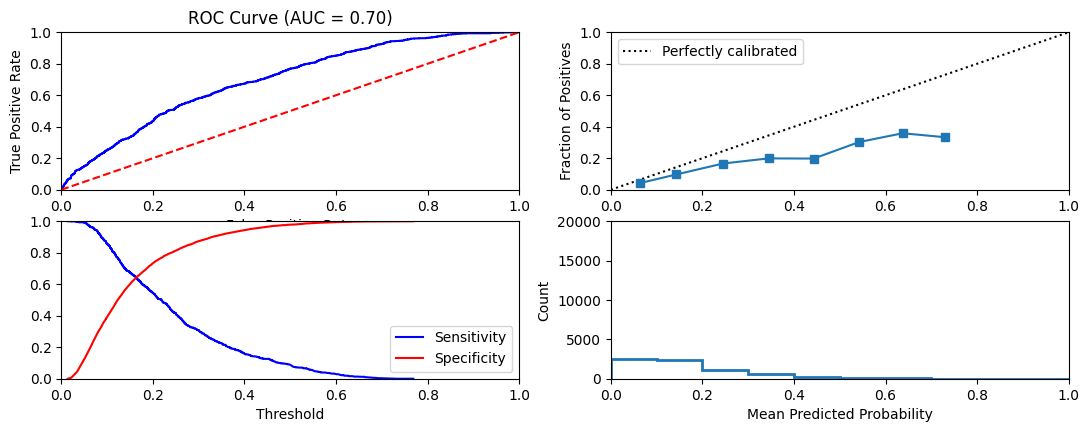


Similarity to LC grade ranking:  0.5992872126162427
Brier score: 0.09757259920222139
Were parameters on edge? : True
Score variations around CV search grid : 2.446918694976698
[0.85811111 0.85822222 0.85755556 0.85788889 0.85755556 0.85755556
 0.85155556 0.85688889 0.83722222 0.853      0.85811111 0.84366667]


In [56]:
## Define the time window of your train and test data
start_date_train = pd.to_datetime('2016-01-01')
end_date_train = pd.to_datetime('2016-12-31')
start_date_test = pd.to_datetime('2017-01-01')
end_date_test = pd.to_datetime('2017-12-31')

data_dict_test = prepare_data(date_range_train = (start_date_train, end_date_train), 
                         date_range_test = (start_date_test, end_date_test),
                         n_samples_train = 9000, n_samples_test = 7000, feature_subset = your_features)

## Train and test YOURMODEL using this data
mlp = MLPClassifier(random_state=default_seed)
cv_parameters = {
    'hidden_layer_sizes': [(100,), (50,), (50, 25)],
    'activation': ['logistic', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.01],
}

mlp = fit_classification(mlp, data_dict_test, cv_parameters=cv_parameters, model_name='Multi-layer Perceptron')

In [151]:
# from joblib import dump, load

# dump(mlp, 'mlp_model.joblib')

In [ ]:
# from joblib import dump, load

# # Save the model to a file
# dump(mlp_model, 'mlp_model.joblib')

# # Load the model from a file
# mlp_model_loaded = load('mlp_model.joblib')

## Train and test YOURMODEL on the original data

In [60]:
dir_cs = "C:\\Users\\kolpe\\Documents\\MLPS Project\\2003_download" # path to the directory where all the *.csv.zip files are located

import os
# Define the output path for the pickle
# pickle_file = 'C:\\Users\\krist\\Documents\\MLPS Project\\cleanData' + "clean_data.pickle" # path to save cleaned data

# Identify the columns we'll be keeping from the dataset
cols_to_pick = ['id',
'loan_amnt',
'funded_amnt',
'funded_amnt_inv',
'term',
'int_rate',
'installment',
'grade',
'sub_grade',
'emp_title',
'emp_length',
'home_ownership',
'annual_inc',
'verification_status',
'issue_d',
'loan_status',
'purpose',
'title',
'zip_code',
'addr_state',
'dti',
'total_pymnt',
'delinq_2yrs',
'earliest_cr_line',
'open_acc',
'pub_rec',
'last_pymnt_d',
'last_pymnt_amnt',
'fico_range_high',
'fico_range_low',
'last_fico_range_high',
'last_fico_range_low',
'application_type',
'revol_bal',
'revol_util',
'recoveries'] # list of features to use for this study as indicated in the handout

# Identify the type of each of these column based on your CS-Phase 1 response
float_cols = ['loan_amnt', 'funded_amnt','funded_amnt_inv', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'pub_rec','last_fico_range_high',
              'fico_range_low', 'revol_bal', 'total_pymnt','last_fico_range_low', 'fico_range_high','recoveries','last_pymnt_amnt','installment']
cat_cols = ['term', 'grade','sub_grade','emp_title','title', 'emp_length','zip_code','addr_state', 'home_ownership', 'verification_status', 
            'loan_status', 'application_type','purpose', ] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

# Ensure that we have types for every column
assert set(cols_to_pick) - set(float_cols) - set(cat_cols) - set(perc_cols) - set(date_cols) == set(["id"])

# Some of the columns selected will not be used directly in the model,
# but will be used to generate other features.
#
# Create variables specifying the features that will be used

# All categorical columns other than "loan_status" will be used as
# discrete features

discrete_features = list(set(cat_cols) - set(["loan_status"]))

# All numeric columns will be used as continuous features
continuous_features = list(float_cols + perc_cols)

def ingest_files(directory):
    '''
    This function will ingest every file in the specified directory
    into a pandas dataframe. It will return a dictionary containing
    these dataframes, keyed by the file name.

    We assume the directory contains files directly downloaded from
    the link given in the handout, and *only* those files. Thus, we
    assume the files are zipped (pd.read_csv can read zipped files)
    and we assume the first line in each file needs to be skipped.

    Note that each file will be read *without* formatting
    '''

    # If the directory has no trailing slash, add one
    if directory[-1] != "/":
        directory += "/"

    all_files = [file for file in os.listdir(directory) if file.endswith('.csv.zip')] # get list of all files from the directory
    output = {}

    print("Directory " + directory + " has " + str(len(all_files)) + " files:")
    for i in all_files:
        print("    Reading file " + i)
        output[i] = pd.read_csv(directory + i, dtype='str', skiprows=1) # read each with dtype='str' and skip_rows =1

        # Some of the files have "summary" lines that, for example
        # read "Total number of loans number in Policy 1: ....."
        # To remove those lines, find any lines with non-integer IDs
        # and remove them
        invalid_rows = output[i]['id'].apply(lambda x: not x.isnumeric()) # mask rows that have non-integer IDs. Use is_integer method
        if invalid_rows.sum() > 0:
            print("Found " + str(invalid_rows.sum()) + " invalid rows which were removed")
            output[i] = output[i][~invalid_rows] # remove invalid rows

    return output # return dictionary of dataframe

# Ingest the set of files we downloaded using the defined method "ingest_files"
files_cs = ingest_files(dir_cs) # dictioary of (filename, dataframe) as (key, value)

data_cs = pd.concat(files_cs.values(), ignore_index=True) # combine "files_cs" into a pandas dataframe
data_cs.reset_index(drop=True, inplace=True)             # resent index with drop = True

# Keep only the columns of interest from 'data_cs'
final_data = data_cs[cols_to_pick] 

print("Starting with " + str(len(final_data)) + " rows")

# Remember that we read the data as string (without any formatting).
# Now we would typecast the columns based on feature types which you found out in CS Phase 1

# for i in float_cols:
#     final_data[i] = final_data[i].astype(float) # typecast float columns

# def clean_perc(x):
#     if pd.isnull(x):
#         return np.nan
#     else:
#         return float(x.strip()[:-1])

# for i in perc_cols:
#     final_data[i] = final_data[i].apply(clean_perc).astype(float) # apply clean_perc to percentage columns

# def clean_date(x):
#     if pd.isnull(x):
#         return None
#     else:
#         return datetime.datetime.strptime( x, "%b-%Y").date()

# for i in date_cols:
#     final_data[i] = final_data[i].apply(clean_date) # typecast date cloumns to datatime using clean_date

# for i in cat_cols:
#     final_data[i] = final_data[i].apply(lambda x: None if pd.isnull(x) or x.strip() == '' else x) # for categorical features if the value is null/empty set it to None

# final_data['issue_d'] = pd.to_datetime(final_data['issue_d'])
# final_data['last_pymnt_d'] = pd.to_datetime(final_data['last_pymnt_d'])
# final_data['earliest_cr_line'] = pd.to_datetime(final_data['earliest_cr_line'])

# final_data['loan_length'] = (final_data.last_pymnt_d - final_data.issue_d) / np.timedelta64(1, 'm')
# n_rows = len(final_data)



Directory C:\Users\kolpe\Documents\MLPS Project\2003_download/ has 20 files:
    Reading file LoanStats3a_securev1.csv.zip
Found 3 invalid rows which were removed
    Reading file LoanStats3b_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3c_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats3d_securev1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q3.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2016Q4.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q1.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_securev1_2017Q2.csv.zip
Found 2 invalid rows which were removed
    Reading file LoanStats_secure

In [63]:
# final_data = final_data[final_data['loan_length'] != 0] # select rows where loan_length is not 0.

final_data.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,...,last_pymnt_d,last_pymnt_amnt,fico_range_high,fico_range_low,last_fico_range_high,last_fico_range_low,application_type,revol_bal,revol_util,recoveries
0,1077501,5000,5000,4975,36 months,10.65%,162.87,B,B2,NaN,...,Jan-2015,171.62,739,735,719,715,Individual,13648,83.7%,0.0
1,1077430,2500,2500,2500,60 months,15.27%,59.83,C,C4,Ryder,...,Apr-2013,119.66,744,740,499,0,Individual,1687,9.4%,122.9
2,1077175,2400,2400,2400,36 months,15.96%,84.33,C,C5,NaN,...,Jun-2014,649.91,739,735,739,735,Individual,2956,98.5%,0.0
3,1076863,10000,10000,10000,36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,...,Jan-2015,357.48,694,690,604,600,Individual,5598,21%,0.0
4,1075358,3000,3000,3000,60 months,12.69%,67.79,B,B5,University Medical Group,...,Jan-2017,67.3,699,695,684,680,Individual,27783,53.9%,0.0


In [ ]:
float_cols = ['loan_amnt', 'funded_amnt','funded_amnt_inv', 'annual_inc', 'dti', 'delinq_2yrs', 'open_acc', 'pub_rec','last_fico_range_high',
              'fico_range_low', 'revol_bal', 'total_pymnt','last_fico_range_low', 'fico_range_high','recoveries','last_pymnt_amnt','installment']
cat_cols = ['term', 'grade','sub_grade','emp_title','title', 'emp_length','zip_code','addr_state', 'home_ownership', 'verification_status', 
            'loan_status', 'application_type','purpose', ] # categorical features
perc_cols = ['int_rate', 'revol_util']
date_cols = ['issue_d', 'earliest_cr_line', 'last_pymnt_d']

In [103]:
def clean_date(x):
    if pd.isnull(x):
        return None
    else:
        return datetime.strptime( x, "%b-%Y").date()

for i in date_cols:
    final_data[i] = final_data[i].apply(clean_date) # typecast date cloumns to datatime using clean_date

for i in cat_cols:
    final_data[i] = final_data[i].apply(lambda x: None if pd.isnull(x) or x.strip() == '' else x) # for categorical features if the value is null/empty set it to None

final_data['issue_d'] = pd.to_datetime(final_data['issue_d'])
final_data['last_pymnt_d'] = pd.to_datetime(final_data['last_pymnt_d'])
final_data['earliest_cr_line'] = pd.to_datetime(final_data['earliest_cr_line'])

In [85]:
final_data["outcome"] = final_data["loan_status"].apply(lambda x: True if x in ["Charged Off", "Default"] else False)

In [108]:
continuous_features = ['loan_amnt', 'open_acc','funded_amnt','funded_amnt_inv', 'annual_inc', 'dti', 'fico_range_low','fico_range_high','last_fico_range_high', 'last_fico_range_low','revol_bal', 'total_pymnt', 'recoveries','last_pymnt_amnt','installment']
discrete_features = ['delinq_2yrs','open_acc','pub_rec','term','grade','sub_grade','emp_length','home_ownership', 'verification_status','loan_status', 'application_type','purpose']

In [109]:
final_data['train'] = np.random.choice([True, False], size=len(final_data), p=[0.7, 0.3])

In [110]:
X_continuous = final_data[continuous_features].values

X_discrete = pd.get_dummies(final_data[discrete_features], dummy_na = True, prefix_sep = "::", drop_first = True)
discrete_features_dummies = X_discrete.columns.tolist()
X_discrete = X_discrete.values

X = np.concatenate( (X_continuous, X_discrete), axis = 1 )

y = final_data.outcome.values

train = final_data.train.values

In [115]:
date_range_train = (data.issue_d.min(), data.issue_d.max())
print(date_range_train)
date_range_test = (data.issue_d.min(), data.issue_d.max())
print(date_range_test)


(Timestamp('2007-06-01 00:00:00'), Timestamp('2019-12-01 00:00:00'))
(Timestamp('2007-06-01 00:00:00'), Timestamp('2019-12-01 00:00:00'))


In [105]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2777776 entries, 0 to 2777775
Data columns (total 38 columns):
 #   Column                Dtype         
---  ------                -----         
 0   id                    object        
 1   loan_amnt             float64       
 2   funded_amnt           float64       
 3   funded_amnt_inv       float64       
 4   term                  object        
 5   int_rate              float64       
 6   installment           float64       
 7   grade                 object        
 8   sub_grade             object        
 9   emp_title             object        
 10  emp_length            object        
 11  home_ownership        object        
 12  annual_inc            float64       
 13  verification_status   object        
 14  issue_d               datetime64[ns]
 15  loan_status           object        
 16  purpose               object        
 17  title                 object        
 18  zip_code              object        
 19  

In [113]:
data = final_data.copy()

In [210]:
your_features = continuous_features + discrete_features
# prepare the train, test data for training models
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

## Test regression models

In [155]:
def fit_regression(model, data_dict,
                      cv_parameters = {},
                      separate = False, 
                      model_name = None,
                      random_state = default_seed,
                      output_to_file = True,
                      print_to_screen = True):
    '''
    This function will fit a regression model to data and print various evaluation
    measures. It expects the following parameters
      - model: an sklearn model object
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - separate: a Boolean variable indicating whether we fit models for 
                  defaulted and non-defaulted loans separately
      - cv_parameters: a dictionary of parameters that should be optimized
                       over using cross-validation. Specifically, each named
                       entry in the dictionary should correspond to a parameter,
                       and each element should be a list containing the values
                       to optimize over      
      - model_name: the name of the model being fit, for printouts
      - random_state: the random seed to use
      - output_to_file: if the results will be saved to the output file
      - print_to_screen: if the results will be printed on screen
    
    This function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - model: the best fitted model
      - predicted_return: prediction result based on the test set
      - predicted_regular_return: prediction result for non-defaulted loans (valid if separate == True)
      - predicted_default_return: prediction result for defaulted loans (valid if separate == True)
      - r2_scores: the testing r2_score(s) for the best fitted model
    '''
    
    np.random.seed(random_state)
    
    # --------------------------
    #   Step 1 - Load the data
    # --------------------------
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    X_train = data_dict['X_train']
    filter_train = data_dict['train_set']  

    X_test = data_dict['X_test']
    filter_test = data_dict['test_set']
    out = {}
    
    for ret_col in col_list:
        
        y_train = data.loc[filter_train, ret_col].values
        y_test = data.loc[filter_test, ret_col].values

        # --------------------------
        #   Step 2 - Fit the model
        # --------------------------

        if separate:
            outcome_train = data.loc[filter_train, 'outcome']
            outcome_test = data.loc[filter_test, 'outcome']

            # Train two separate regressors for defaulted and non-defaulted loans
            X_train_0 = X_train[outcome_train == False]
            y_train_0 = y_train[outcome_train == False]
            X_test_0 = X_test[outcome_test == False]
            y_test_0 = y_test[outcome_test == False]

            X_train_1 = X_train[outcome_train == True]
            y_train_1 = y_train[outcome_train == True]
            X_test_1 = X_test[outcome_test == True]
            y_test_1 = y_test[outcome_test == True]

            cv_model_0 = GridSearchCV(model, cv_parameters, scoring='r2')
            cv_model_1 = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model_0.fit(X_train_0, y_train_0)
            cv_model_1.fit(X_train_1, y_train_1)
            end_time = time.time()

            best_model_0 = cv_model_0.best_estimator_
            best_model_1 = cv_model_1.best_estimator_
            
            if print_to_screen:

                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print("model_0:",cv_model_0.best_params_, "model_1",cv_model_1.best_params_)

            predicted_regular_return = best_model_0.predict(X_test)
            predicted_default_return = best_model_1.predict(X_test)
            
            if print_to_screen:
                print("")
                print("Testing r2 scores:")
            # Here we use different testing set to report the performance
            test_scores = {'model_0':r2_score(y_test_0,best_model_0.predict(X_test_0)),
                              'model_1':r2_score(y_test_1,best_model_1.predict(X_test_1))}
            if print_to_screen:
                print("model_0:", test_scores['model_0'])
                print("model_1:", test_scores['model_1'])

            cv_objects = {'model_0':cv_model_0, 'model_1':cv_model_1}
            out[ret_col] = { 'model_0':best_model_0, 'model_1':best_model_1, 'predicted_regular_return':predicted_regular_return,
                      'predicted_default_return':predicted_default_return,'r2_scores':test_scores }

        else:
            cv_model = GridSearchCV(model, cv_parameters, scoring='r2')

            start_time = time.time()
            cv_model.fit(X_train, y_train)
            end_time = time.time()

            best_model = cv_model.best_estimator_
            
            if print_to_screen:
                if model_name != None:
                    print("=========================================================")
                    print("  Model: " + model_name + "  Return column: " + ret_col)
                    print("=========================================================")

                print("Fit time: " + str(round(end_time - start_time, 2)) + " seconds")
                print("Optimal parameters:")
                print(cv_model.best_params_)

            predicted_return = best_model.predict(X_test)
            test_scores = {'model':r2_score(y_test,predicted_return)}
            if print_to_screen:
                print("")
                print("Testing r2 score:", test_scores['model'])

            cv_objects = {'model':cv_model}
            out[ret_col] = {'model':best_model, 'predicted_return':predicted_return, 'r2_scores':r2_score(y_test,predicted_return)}

        # Output the results to a file
        if output_to_file:
            for i in cv_objects:
                # Check whether any of the CV parameters are on the edge of
                # the search space
                opt_params_on_edge = find_opt_params_on_edge(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::search_on_edge", opt_params_on_edge)
                if print_to_screen:
                    print("Were parameters on edge (" + i + ") : " + str(opt_params_on_edge))

                # Find out how different the scores are for the different values
                # tested for by cross-validation. If they're not too different, then
                # even if the parameters are off the edge of the search grid, we should
                # be ok
                score_variation = find_score_variation(cv_objects[i])
                dump_to_output(model_name + "::" + ret_col + "::score_variation", score_variation)
                if print_to_screen:
                    print("Score variations around CV search grid (" + i + ") : " + str(score_variation))

                # Print out all the scores
                dump_to_output(model_name + "::all_cv_scores", str(cv_objects[i].cv_results_['mean_test_score']))
                if print_to_screen:
                    print("All test scores : " + str(cv_objects[i].cv_results_['mean_test_score']) )

                # Dump the AUC to file
                dump_to_output( model_name + "::" + ret_col + "::r2", test_scores[i] )

    return out

In [218]:
your_features = ['loan_amnt', 'funded_amnt', 'int_rate', 'annual_inc', 'delinq_2yrs',
    'open_acc', 'pub_rec',  'revol_bal',
    'revol_util', 'total_pymnt', 'recoveries', 'loan_length', 'ret_PESS',
    'ret_OPT', 'ret_INTa', 'ret_INTb', 'term', 'emp_length',
    'home_ownership', 'purpose', 'term_num']

In [145]:
data_dict = prepare_data(feature_subset = your_features)

all_features = pd.Series(continuous_features + discrete_features_dummies)
idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                     if j.split("::")[0] in your_features]
selected_features = all_features[idx]
selected_features.reset_index(drop=True,inplace=True)

### $l_1$ regularized linear regression

In [156]:
## First, trying l1 regularized linear regression with hyper-parameters
from sklearn.linear_model import Lasso
lasso = Lasso()
cv_parameters = {
    'alpha': [0.1, 0.01, 0.001]
}

# Fit l1 regularized linear regression with hyperparameters
reg_lasso = fit_regression(lasso, data_dict, cv_parameters=cv_parameters, model_name='Lasso Regression')

  Model: Lasso Regression  Return column: ret_PESS
Fit time: 5.03 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.039803889121577174
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -4.563315032675702
All test scores : [-0.70346389 -0.70346389 -0.67276357]
  Model: Lasso Regression  Return column: ret_OPT
Fit time: 7.87 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.037057312983788115
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -11.847337361381674
All test scores : [-0.15669701 -0.15669701 -0.14009901]
  Model: Lasso Regression  Return column: ret_INTa
Fit time: 22.3 seconds
Optimal parameters:
{'alpha': 0.1}

Testing r2 score: 0.04172399030610141
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -2.078183392867858
All test scores : [-0.62862123 -0.64168514 -0.63471567]
  Model: Lasso Regression  Return column: ret_INTb
Fit time: 

### $l_2$ regularized linear regressor

In [157]:
## trying l2 regularized linear regression with hyper-parameters

from sklearn.linear_model import Ridge

# Define the hyperparameters grid for cross-validation
cv_parameters = {
    'alpha': [0.1, 0.01, 0.001]
}

# Fit l2 regularized linear regression with hyperparameters
reg_ridge = fit_regression(Ridge(), data_dict, cv_parameters=cv_parameters, model_name='Ridge Regression')


  Model: Ridge Regression  Return column: ret_PESS
Fit time: 0.3 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: 0.0710886952444143
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -0.2773282153274677
All test scores : [-0.648691   -0.64689697 -0.64756305]
  Model: Ridge Regression  Return column: ret_OPT
Fit time: 0.26 seconds
Optimal parameters:
{'alpha': 0.001}

Testing r2 score: 0.05688568160682883
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.3590046256530256
All test scores : [-0.12504542 -0.12474688 -0.12459811]
  Model: Ridge Regression  Return column: ret_INTa
Fit time: 0.26 seconds
Optimal parameters:
{'alpha': 0.01}

Testing r2 score: 0.07909415960555155
Were parameters on edge (model) : False
Score variations around CV search grid (model) : -0.4327298309430636
All test scores : [-0.62644077 -0.62374166 -0.62568679]
  Model: Ridge Regression  Return column: ret_INTb
Fit time: 

### Multi-layer perceptron regressor

In [158]:
## trying multi-layer perceptron regression with hyper-parameters

cv_parameters = {
    'hidden_layer_sizes': [(100,), (50,), (50, 25)],
    'activation': ['logistic', 'relu'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.01],
}

# Fit Multi-layer Perceptron regression with hyperparameters
reg_mlp = fit_regression(MLPRegressor(random_state=default_seed), data_dict, cv_parameters=cv_parameters, model_name='Multi-layer Perceptron Regression')

  Model: Multi-layer Perceptron Regression  Return column: ret_PESS
Fit time: 130.38 seconds
Optimal parameters:
{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'solver': 'adam'}

Testing r2 score: 0.09325605738140241
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -106.77546630867175
All test scores : [-0.582932   -0.75205072 -0.73905856 -0.59351011 -0.64888923 -0.75985023
 -0.67060159 -0.65290268 -0.61042958 -0.52542933 -0.36747601 -0.62657385]
  Model: Multi-layer Perceptron Regression  Return column: ret_OPT
Fit time: 130.53 seconds
Optimal parameters:
{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100,), 'solver': 'adam'}

Testing r2 score: 0.08548066426160705
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -597.5656066720454
All test scores : [-0.06437499 -0.11167923 -0.113482   -0.05623326 -0.11228636 -0.11511353
 -0.08796269 -0.07645336 -0.10649933 -0.01650218 -0.090

### Random forest regressor

In [160]:
## trying random forest regression with hyper-parameters

cv_parameters = {
    'n_estimators': [50, 100],
    'max_depth': [3, 7],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [2, 4]
}

# Fit Random Forest regression with hyperparameters
reg_rf = fit_regression(RandomForestRegressor(random_state=default_seed), data_dict, cv_parameters=cv_parameters, model_name='Random Forest Regression')

  Model: Random Forest Regression  Return column: ret_PESS
Fit time: 274.18 seconds
Optimal parameters:
{'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Testing r2 score: 0.13787894865114747
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -8.677756675806485
All test scores : [-0.57421442 -0.56781521 -0.57421442 -0.56781521 -0.57414839 -0.56778366
 -0.57414839 -0.56778366 -0.53212039 -0.52955886 -0.53107484 -0.52930366
 -0.52930139 -0.52851102 -0.52923837 -0.52836426]
  Model: Random Forest Regression  Return column: ret_OPT
Fit time: 269.47 seconds
Optimal parameters:
{'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}

Testing r2 score: 0.11588244248389168
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -853.4164431445026
All test scores : [-0.00550752 -0.00517323 -0.00550752 -0.00517323 -0.00547632 -0.00513212
 -0.00547632 -0.00513212

## Test investment strategies 
Now we test several investment strategies using the learning models above

In [192]:
def test_investments(data_dict,
                        classifier = None,
                        regressor = None,
                        strategy = 'Random', 
                        num_loans = 1000,
                        random_state = default_seed,
                        output_to_file = True):
    '''
    This function tests a variety of investment methodologies and their returns. 
    It will run its tests on the loans defined by the test_set element of the data
    dictionary.
    
    It is currently able to test four strategies
      - random: invest in a random set of loans
      - default-based: score each loan by probability of default, and only invest
                 in the "safest" loans (i.e., those with the lowest probabilities
                 of default)
      - return-based: train a single regression model to predict the expected return
                    of loans in the past. Then, for loans we could invest in, simply
                    rank them by their expected returns and invest in that order.
      - default-& return-based: train two regression models to predict the expected return of
                   defaulted loans and non-defaulted loans in the training set. Then,
                   for each potential loan we could invest in, predict the probability
                   the loan will default, its return if it doesn't default and its
                   return if it does. Then, calculate a weighted combination of
                   the latter using the former to find a predicted return. Rank the
                   loans by this expected return, and invest in that order
    
    It expects the following parameters
      - data_dict: the dictionary containing both training and testing data;
                   returned by the prepare_data function
      - classifier: a fitted model object which is returned by the fit_classification function.
      - regressor: a fitted model object which is returned by the fit_regression function.
      - strategy: the name of the strategy; one of the three listed above
      - num_loans: the number of loans to be included in the test portfolio
      - num_samples: the number of random samples used to compute average return ()   
      - random_state: the random seed to use when selecting a subset of rows
      - output_to_file: if the results will be saved to the output file
      
    The function returns a dictionary FOR EACH RETURN DEFINITION with the following entries
      - strategy: the name of the strategy
      - average return: the return of the strategy based on the testing set
      - test data: the updated Dataframe of testing data. Useful in the optimization section
    '''
    
    np.random.seed(random_state)
    
    # Retrieve the rows that were used to train and test  the
    # classification model
    train_set = data_dict['train_set']
    test_set = data_dict['test_set']
    
    col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
    
    # Create a dataframe for testing, including the score
    data_test = data.loc[test_set,:]
    out = {}
    
    for ret_col in col_list:    
    
        if strategy == 'Random':
            # Randomize the order of the rows in the datframe
            data_test = data_test.sample(frac = 1).reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test.sample(n=num_loans, random_state=random_state)

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
        
        elif strategy == 'Return-based':
            
            colname = 'predicted_return_' + ret_col 

            data_test[colname] = regressor[ret_col]['predicted_return']

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test.head(num_loans)

            ## Find their return
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue
            
        # Get the predicted scores, if the strategy is not Random or just Regression
        try:
            print("classifier['y_pred_probs']: ")
            y_pred_score = classifier['y_pred_probs']
            print("y_pred_score: ",y_pred_score)
        except:
            y_pred_score = classifier['y_pred_score']

        data_test['score'] = y_pred_score


        if strategy == 'Default-based':
            # Sort the test data by the score
            data_test = data_test.sort_values(by='score').reset_index(drop = True)

            ## Select num_loans to invest in
            pf_test = data_test.head(num_loans)

            ## Find the average return for these loans
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue


        elif strategy == 'Default-return-based':

            # Load the predicted returns
            data_test['predicted_regular_return'] = regressor[ret_col]['predicted_regular_return']
            data_test['predicted_default_return'] = regressor[ret_col]['predicted_default_return']

            # Compute expectation
            colname = 'predicted_return_' + ret_col 
            
            data_test[colname] = ( (1-data_test.score)*data_test.predicted_regular_return + 
                                             data_test.score*data_test.predicted_default_return )

            # Sort the loans by predicted return
            data_test = data_test.sort_values(by=colname, ascending = False).reset_index(drop = True)

            ## Pick num_loans loans
            pf_test = data_test.head(num_loans)

            ## Find their return
            ret_test = pf_test[ret_col].mean()

            # Return
            out[ret_col] = {'strategy':strategy, 'average return':ret_test, 'test data':data_test}

            # Dump the strategy performance to file
            if output_to_file:
                dump_to_output(strategy + "," + ret_col + "::average return", ret_test )

            continue

        else:
            return 'Not a valid strategy'
        
    return out

  Model: Random Forest
Fit time: 4.81 seconds
Optimal parameters:
{'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}

Accuracy-maximizing threshold was: 0.4937620068782023
Accuracy:  0.90715
              precision    recall  f1-score   support

  No default     0.9108    0.9950    0.9511     18134
     Default     0.5238    0.0531    0.0964      1866

    accuracy                         0.9072     20000
   macro avg     0.7173    0.5240    0.5237     20000
weighted avg     0.8747    0.9072    0.8713     20000



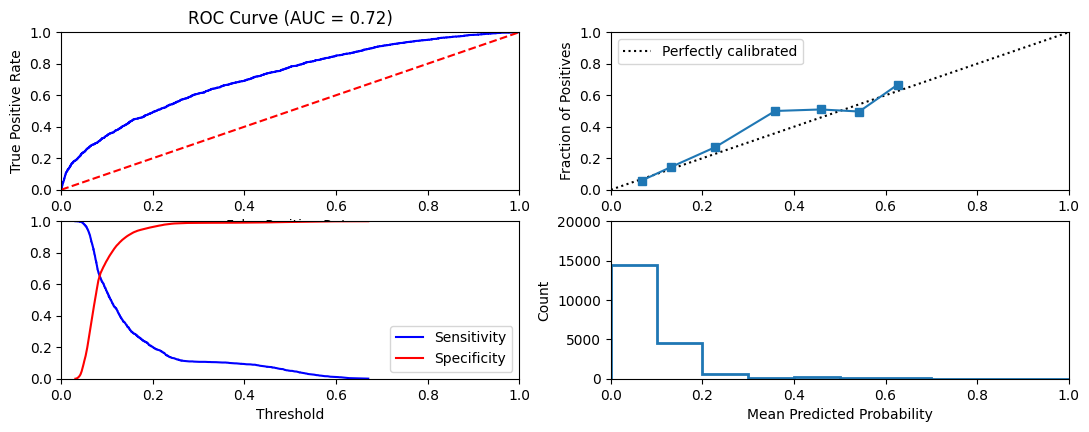


Similarity to LC grade ranking:  0.5822117936770921
Brier score: 0.07811176477576495
Were parameters on edge? : True
Score variations around CV search grid : 0.0
[0.90396667]


{'model': RandomForestClassifier(max_depth=7, min_samples_leaf=4, min_samples_split=10,
                        n_estimators=50, random_state=1),
 'y_pred_labels': array([False, False, False, ..., False, False, False]),
 'y_pred_probs': array([0.06892379, 0.05230264, 0.07843875, ..., 0.1458885 , 0.06292224,
        0.22799071])}

In [180]:
cv_parameters = {
    'max_depth': [7],
    'min_samples_leaf': [4],
    'min_samples_split': [10],
    'n_estimators': [50]
}
rfm = RandomForestClassifier(random_state=default_seed)
rfm = fit_classification(model=rfm, data_dict=data_dict,
                                           cv_parameters=cv_parameters, model_name="Random Forest")

rfm

In [199]:
cv_parameters = {
    'max_depth': [7],
    'min_samples_leaf': [4],
    'min_samples_split': [10],
    'n_estimators': [50]
}

# Fit the regression model
reg_rf = fit_regression(RandomForestRegressor(random_state=default_seed), data_dict, cv_parameters=cv_parameters, model_name='Random Forest Regression')

  Model: Random Forest Regression  Return column: ret_PESS
Fit time: 19.76 seconds
Optimal parameters:
{'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}

Testing r2 score: 0.13768174385998844
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0
All test scores : [-0.52923837]
  Model: Random Forest Regression  Return column: ret_OPT
Fit time: 19.2 seconds
Optimal parameters:
{'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}

Testing r2 score: 0.11608549193865336
Were parameters on edge (model) : True
Score variations around CV search grid (model) : -0.0
All test scores : [-0.00151352]
  Model: Random Forest Regression  Return column: ret_INTa
Fit time: 19.63 seconds
Optimal parameters:
{'max_depth': 7, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 50}

Testing r2 score: 0.15999563229059
Were parameters on edge (model) : True
Score variations around CV search g

In [240]:
## Test investment strategies using the best performing regressor

col_list = ['ret_PESS', 'ret_OPT', 'ret_INTa', 'ret_INTb']
test_strategy = 'Random'
returns_random = {ret_col:[] for ret_col in col_list}
returns_def = {ret_col:[] for ret_col in col_list}
returns_ret = {ret_col:[] for ret_col in col_list}
returns_defRet = {ret_col:[] for ret_col in col_list}

# print('strategy:',test_strategy) 
for i in range(0,100):
    np.random.seed(i)
    default_seed = i
    
    data['train'] = np.random.choice([True, False], size=len(data), p=[0.7, 0.3])
    X = np.concatenate( (X_continuous, X_discrete), axis = 1 )
    
    y = data.outcome.values
    
    train = data.train.values
    data_dict = prepare_data(feature_subset = your_features,random_state=i)

    all_features = pd.Series(continuous_features + discrete_features_dummies)
    idx = [i for i, j in enumerate(continuous_features + discrete_features_dummies)
                                                         if j.split("::")[0] in your_features]
    selected_features = all_features[idx]
    selected_features.reset_index(drop=True,inplace=True)
    
    cv_parameters = {
    'max_depth': [7],
    'min_samples_leaf': [4],
    'min_samples_split': [10],
    'n_estimators': [50]
    }
    rfm = RandomForestClassifier(random_state=i)
    rfm = fit_classification(model=rfm, data_dict=data_dict,
                                           cv_parameters=cv_parameters, model_name="Random Forest",print_to_screen=False,random_state=i)
    reg_rf = fit_regression(RandomForestRegressor(random_state=default_seed), data_dict, cv_parameters=cv_parameters, model_name='Random Forest Regression',print_to_screen=False,random_state=i)
    reg_separate = fit_regression(RandomForestRegressor(random_state=default_seed), data_dict, cv_parameters=cv_parameters, separate=True, model_name='Random Forest Regression Separate',print_to_screen=False,random_state=i)

    strat_rand = test_investments(data_dict_test, classifier=rfm, strategy=test_strategy, output_to_file=False, num_loans=1000)
    strat_def = test_investments(data_dict, classifier=rfm, strategy='Default-based', output_to_file=False, num_loans=1000)
    strat_ret = test_investments(data_dict, regressor=reg_rf, strategy='Return-based', output_to_file=False, num_loans=1000)
    strat_defret = test_investments(data_dict, regressor=reg_separate, classifier=rfm, strategy='Default-return-based', output_to_file=False, num_loans=1000)

    for ret_col in col_list:
        # print(ret_col + ': ' + str(strat_rand[ret_col]['average return']))
        returns_random[ret_col].append(strat_rand[ret_col]['average return'])
        returns_def[ret_col].append(strat_def[ret_col]['average return'])
        returns_ret[ret_col].append(strat_ret[ret_col]['average return'])
        returns_defRet[ret_col].append(strat_defret[ret_col]['average return'])
    if (i+1)%10==0:
        print("Iterations performed: ",i+1)

classifier['y_pred_probs']: 
y_pred_score:  [0.14293555 0.05333539 0.0532487  ... 0.11440789 0.17925877 0.07127846]
classifier['y_pred_probs']: 
y_pred_score:  [0.14293555 0.05333539 0.0532487  ... 0.11440789 0.17925877 0.07127846]
classifier['y_pred_probs']: 
y_pred_score:  [0.14293555 0.05333539 0.0532487  ... 0.11440789 0.17925877 0.07127846]
classifier['y_pred_probs']: 
y_pred_score:  [0.14293555 0.05333539 0.0532487  ... 0.11440789 0.17925877 0.07127846]
classifier['y_pred_probs']: 
y_pred_score:  [0.14293555 0.05333539 0.0532487  ... 0.11440789 0.17925877 0.07127846]
classifier['y_pred_probs']: 
y_pred_score:  [0.14293555 0.05333539 0.0532487  ... 0.11440789 0.17925877 0.07127846]
classifier['y_pred_probs']: 
y_pred_score:  [0.14293555 0.05333539 0.0532487  ... 0.11440789 0.17925877 0.07127846]
classifier['y_pred_probs']: 
y_pred_score:  [0.14293555 0.05333539 0.0532487  ... 0.11440789 0.17925877 0.07127846]
classifier['y_pred_probs']: 
y_pred_score:  [0.06892379 0.05230264 0.078

In [231]:
for ret_col in col_list:
    print(ret_col, "- Number of values: ", len(returns_random[ret_col]))

ret_PESS - Number of values:  100
ret_OPT - Number of values:  100
ret_INTa - Number of values:  100
ret_INTb - Number of values:  100


In [238]:
import statistics
for ret_col in col_list:
    print(statistics.mean(returns_random[ret_col]))

-0.059187050894269205
0.008815325939325592
-2.027738547455661
-0.6352511800560496


In [242]:
for ret_col in col_list:
    print(ret_col, "- Number of values: ", len(returns_def[ret_col]))

ret_PESS - Number of values:  100
ret_OPT - Number of values:  100
ret_INTa - Number of values:  100
ret_INTb - Number of values:  100


In [243]:
for ret_col in col_list:
    print(statistics.mean(returns_def[ret_col]))

0.01562125764331302
0.056207780592307834
2.536437951037827
4.170641328987536


In [244]:
for ret_col in col_list:
    print(ret_col, "- Number of values: ", len(returns_ret[ret_col]))

ret_PESS - Number of values:  100
ret_OPT - Number of values:  100
ret_INTa - Number of values:  100
ret_INTb - Number of values:  100


In [245]:
for ret_col in col_list:
    print(statistics.mean(returns_ret[ret_col]))

0.04577851405721596
0.05425594353926825
2.56403619648798
4.215963943209448


In [246]:
for ret_col in col_list:
    print(ret_col, "- Number of values: ", len(returns_defRet[ret_col]))

ret_PESS - Number of values:  100
ret_OPT - Number of values:  100
ret_INTa - Number of values:  100
ret_INTb - Number of values:  100


In [247]:
for ret_col in col_list:
    print(statistics.mean(returns_defRet[ret_col]))

0.03948508131392505
0.05636194371129788
2.6022420011701453
4.242712701395301


In [248]:
# test_strategy = 'Default-based'

# print('strategy:',test_strategy)
# strat_def = test_investments(data_dict, classifier=rfm, strategy=test_strategy)

# for ret_col in col_list:
#     print(ret_col + ': ' + str(strat_def[ret_col]['average return']))

In [249]:
# test_strategy = 'Return-based'

# print('strategy:',test_strategy)
# strat_ret = test_investments(data_dict, regressor=reg_rf, strategy=test_strategy)

# for ret_col in col_list:
#     print(ret_col + ': ' + str(strat_ret[ret_col]['average return']))

In [250]:
# test_strategy = 'Default-return-based'

# ## For the Default-return-based strategy we need to fit a new regressor with separate = True
# cv_parameters = {
#     'max_depth': [7],
#     'min_samples_leaf': [4],
#     'min_samples_split': [10],
#     'n_estimators': [50]
# }

# reg_separate = fit_regression(RandomForestRegressor(random_state=default_seed), data_dict, cv_parameters=cv_parameters, separate=True, model_name='Random Forest Regression Separate')

# print('strategy:',test_strategy)
# strat_defret = test_investments(data_dict, regressor=reg_separate, classifier=rfm, strategy=test_strategy)

# for ret_col in col_list:
#     print(ret_col + ': ' + str(strat_defret[ret_col]['average return']))

## Sensitivity test of portfolio size

classifier['y_pred_probs']: 
y_pred_score:  [0.06892379 0.05230264 0.07843875 ... 0.1458885  0.06292224 0.22799071]
classifier['y_pred_probs']: 
y_pred_score:  [0.06892379 0.05230264 0.07843875 ... 0.1458885  0.06292224 0.22799071]
classifier['y_pred_probs']: 
y_pred_score:  [0.06892379 0.05230264 0.07843875 ... 0.1458885  0.06292224 0.22799071]
classifier['y_pred_probs']: 
y_pred_score:  [0.06892379 0.05230264 0.07843875 ... 0.1458885  0.06292224 0.22799071]
classifier['y_pred_probs']: 
y_pred_score:  [0.06892379 0.05230264 0.07843875 ... 0.1458885  0.06292224 0.22799071]
classifier['y_pred_probs']: 
y_pred_score:  [0.06892379 0.05230264 0.07843875 ... 0.1458885  0.06292224 0.22799071]
classifier['y_pred_probs']: 
y_pred_score:  [0.06892379 0.05230264 0.07843875 ... 0.1458885  0.06292224 0.22799071]
classifier['y_pred_probs']: 
y_pred_score:  [0.06892379 0.05230264 0.07843875 ... 0.1458885  0.06292224 0.22799071]
classifier['y_pred_probs']: 
y_pred_score:  [0.06892379 0.05230264 0.078

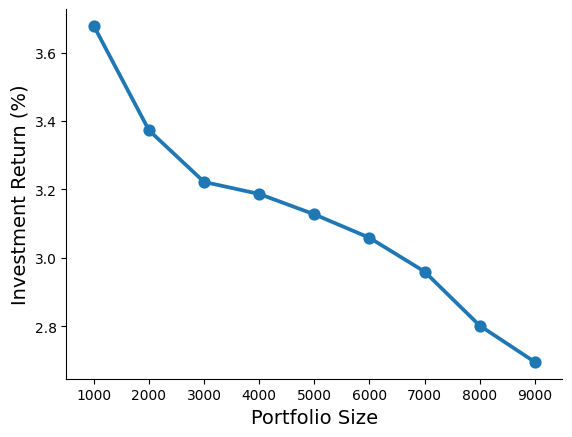

In [209]:
## Test the best-performing data-driven strategy on different portfolio sizes

result_sensitivity = []

## Vary the portfolio size from 1,000 to 10,000
for num_loans in list(range(1000,10000,1000)):

    reg_0 = test_investments(data_dict, regressor=reg_separate, classifier=rfm, strategy='Default-return-based', num_loans=num_loans)
    result_sensitivity.append(reg_0['ret_PESS']['average return'])
    
result_sensitivity = np.array(result_sensitivity) * 100
sns.pointplot(x=np.array(list(range(1000,10000,1000))),y=result_sensitivity)
sns.despine()
plt.ylabel('Investment Return (%)',size = 14)
plt.xlabel('Portfolio Size',size = 14)
plt.show()